In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss

import logging
logger = logging.getLogger('qick.qick_asm')
logger.setLevel(logging.ERROR)

from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import InstrumentManager
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
style.use('default')

np.set_printoptions(threshold=sys.maxsize)

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


C:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [2]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

# Tomo analysis

In [4]:
from TomoAnalysis import TomoAnalysis
tomo_analysis = TomoAnalysis(nb_qubits=3)

# Getting ideal rho

Define psi basis

In [5]:
# 2 cardinal points on Bloch sphere for each measurement axis
# psiZ = [qt.basis(3,0), qt.basis(3,1)]
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

psis = dict() # psis in the ZZZ basis
for i, label_numeric in enumerate(tomo_analysis.calib_order_numeric):
    psis.update({label_numeric:tomo_analysis.psi_basis['ZZZ'][i]})
id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))

In [6]:
def name_to_state_2q(init_state): # in format |QA>|QB>
    Qa, Qb, _ = init_state.split('>')
    Qa = Qa[1:]
    Qb = Qb[1:]
    psi_name_dict = {
        '0':psiZ[0],
        '1':psiZ[1],
        '0+1':(psiZ[0]+psiZ[1]).unit(),
        '0-1':(psiZ[0]-psiZ[1]).unit(), 
        '0+i1':(psiZ[0]+1j*psiZ[1]).unit(), 
        '0-i1':(psiZ[0]-1j*psiZ[1]).unit(), 
    }
    try:
        psiA = psi_name_dict[Qa]
    except:
        print(f'QA state {Qa} is not an allowed cardinal state')
    try:
        psiB = psi_name_dict[Qb]
    except:
        print(f'QB state {Qb} is not an allowed cardinal state')
    return qt.tensor(psiA, psiB)

    
def get_qram_qSLR_state_from_rho(init_rho_SI, post_select=False, post_select_state=None):
    """
    init_rho_SI should be a np array
    """
    # in order |00>, |01>, |10>, |11> for Q0 (switch), Q1 (input)
    SI_to_SLR = [psis['000'], -1j*psis['010'], psis['100'], -1j*psis['101']]

    assert np.shape(init_rho_SI) == id2q.shape
    rho_final_SLR = 0*qt.ket2dm(psis['000'])
    print('constructing final state on |switch, out1, out2>')
    for i in range(len(SI_to_SLR)):
        slr_ket_i = SI_to_SLR[i]
        for j in range(len(SI_to_SLR)):
            slr_ket_j = SI_to_SLR[j]
            mat_el = init_rho_SI[i, j]
            rho_final_SLR += mat_el * slr_ket_i * slr_ket_j.dag()
    return rho_final_SLR.unit()

# Run experiment and analysis

In [7]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [8]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
# expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
expt_path = os.path.join(data_path, 'data', 'data_241007')
print('Data will be stored in', expt_path)

Data will be stored in S:\Connie\experiments\qramLL_4QR2\data\data_240617


In [9]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_path = os.path.join(os.getcwd(), config_file)

# config_file = 'config.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)

print('Config will be', config_path)

Config will be S:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


In [10]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [11]:
import Pyro4.util

## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [14]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
print(im.keys())

dict_keys(['Pyro.NameServer', 'Qick60', 'Heman', 'qdac', 'bkp', 'NeonFilament', 'SC_26C1', 'SC_2FF1', 'scqubA', 'scredA', 'scqubB', 'scredB', 'BNCfungen', 'YOKO4', 'Qick187'])


In [15]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Mon Jul 24 13:57:32 2023):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.08

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print('set freq to', lo_freq)
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

## Run experiment and acquire data

### Test 3Q tomo

In [ ]:
save_data = True
saved_files = []

In [ ]:
tomo_qubits = [0, 2, 3] # which qubit/resonator we want to probe

In [ ]:
tomoExpt = meas.TestStateTomo3QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"test_3q_state_tomo_{tomo_qubits[0]}{tomo_qubits[1]}{tomo_qubits[2]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    reps=20000, # reps per measurement basis
    singleshot_reps=30000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
)

print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

if save_data: saved_files.append(tomoExpt.save_data())

In [ ]:
tomo = tomoExpt
# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00062_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

print(meas_order)
print(calib_order)

data = tomo.data
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == tomo_analysis.meas_order)
assert np.all(np.array(tomo.calib_order) == tomo_analysis.calib_order)

n_tomo_raw = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

np.set_printoptions(suppress=True)
print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

### Qram experiment

In [14]:
tomo_qubits = [0, 2, 3] # which qubit/resonators to do tomo on
# tomo_qubits = [0, 1, 2] # which qubit/resonators to do tomo on

In [146]:
save_data = False
saved_files = []

In [147]:
init_state = '|1>|1>' # Q0/Q1 (switch, input)
# init_state = 'Q3Q0_|1>|1>'
# init_state = '|0>|1>' # Q0/Q1 (switch, input)
# init_state = 'Q2Q0_|1>|0>'

# play_pulses = [0] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [1, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
play_pulses = [2, 4] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

# cool_qubits = [0, 1]
cool_qubits = None
readout_cool = True

sync_between_swaps = False

In [151]:
qramExpt = meas.QramProtocol3QTomoExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

# span = 2.161196963262976 # total time [us]
# span = 1.1659462011134218 # total time [us]
span = np.inf
npts = 1
# span = 1.8 # total time [us]
# npts = 120
# span = 0.8 # total time [us]
# npts = 10
if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

qramExpt.cfg.expt = dict(
    # start=0, # start protocol time [us],
    # step=span/npts, # time step [us], 
    # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

    start=span,
    step=0,
    expts=1, # number of different time experiments

    reps=40000, # number of reps per tomo/time step,
    # reps=1000,
    # singleshot_reps=1, # reps per state for singleshot calibration
    singleshot_reps=40000, # reps per state for singleshot calibration
    # singleshot_reps=1000, # reps per state for singleshot calibration
    # singleshot_reps=200,
    post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
    tomo_3q=True, # flag to perform tomo on last time step
    tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
    init_state=init_state,
    play_pulses=play_pulses, # [2, 1, 4, 3]
    sync_between_swaps=sync_between_swaps,
    
    cool_qubits=cool_qubits,
    
    use_IQ_pulse=True,
    plot_IQ=False,
    
    readout_cool=readout_cool,
    n_init_readout=1,
    n_trig=1,
    # init_read_wait_us=5,
    init_read_wait_us=10,
)

# print(qramExpt.cfg)

import Pyro4.util
try:
    qramExpt.acquire(debug=False, progress=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# tomo = qramExpt
# data = tomo.data
# n_tomo_raw = np.array(data['counts_tomo'])
# n_calib = np.array(data['counts_calib'])

# n_tomo_raw_rounds.append(n_tomo_raw)
# n_calib_rounds.append(n_calib)
# n_tomo_rounds.append(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))


timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 76.60441511037776 	 angle (deg): 140.55899339846783 	 threshold ge: 284.51550785954527
Qubit  (2)
ge fidelity (%): 84.58 	 angle (deg): 52.89868536832795 	 threshold ge: 538.2860367490651
Qubit  (3)
ge fidelity (%): 73.9225 	 angle (deg): 173.4203831027385 	 threshold ge: 26.988901198562814


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 62.9625 	 angle (deg): -123.57940234048294 	 threshold ge: 416.8220225350385
thresholds=[284.51550785954527, 416.8220225350385, 538.2860367490651, 26.988901198562814],
angles=[140.55899339846783, -123.57940234048294, 52.89868536832795, 173.4203831027385],
ge_avgs=[[29.459903477647575, -230.2573427951389, -266.3916949598524, -474.4991655327691], [-274.1096103597005, 168.75457174479166, -415.16107898763016, 379.8161561767578], [253.20678680013023, -173.05187026367187, 552.7167545410156, -567.4684443847656], [143.36151903889973, -472.10610014241536, -203.39124490966796, -513.3567428548176]] ,
counts_calib=[[31537, 2879, 2072, 201, 2754, 281, 217, 59], [6002, 28507, 461, 1790, 520, 2483, 51, 186], [3039, 301, 30941, 2617, 258, 33, 2532, 279], [668, 2740, 6357, 27033, 62, 260, 614, 2266], [5057, 573, 347, 74, 29113, 2563, 2022, 251], [925, 4973, 76, 351, 4969, 26487, 368, 1851], [537, 45, 5133, 443, 2830, 249, 28533, 2230], [141, 500, 1108, 4687, 603, 2631, 579

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [152]:
saved_files = [qramExpt.save_data()]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00052_QramProtocol3QTomo.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00052_QramProtocol3QTomo.h5


#### post processing counts

In [153]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [76]:
tomo = qramExpt
data = tomo.data
cfg = tomo.cfg
pulse_dict = qramExpt.pulse_dict
init_state = qramExpt.cfg.expt.init_state

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

print('calib order', tomo_analysis.calib_order)

print('Raw tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib))) 

calib order ['ggg' 'gge' 'geg' 'gee' 'egg' 'ege' 'eeg' 'eee']
Raw tomography counts
[[ 7306  4993 55883  1575  1649  2116  1260   218]
 [ 4958  7410 32271 25028   961  2876   776   720]
 [ 4936  7524 32736 25027  1916  1433   792   636]
 [29807  3179 35574  1918  1276   989  1428   829]
 [16484 16151 22400 14995   763  1659  1034  1514]
 [17379 15317 21659 15833  1343  1021  1498   950]
 [29969  3196 35609  1741  1258   958  1455   814]
 [16949 15911 21626 15043   818  1802  1127  1724]
 [16261 16171 22196 14650  1448  1257  1772  1245]
 [ 4859  3932 30540   990  4392  3260 26137   890]
 [ 3282  5702 18373 13432  2797  4663 15335 11416]
 [ 4137  5012 18175 13330  3390  4279 15478 11199]
 [16648  2409 20312  1626 13874  1925 16931  1275]
 [ 9511  9730 13139  8975  7773  7950 10603  7319]
 [10600  8501 12793  8963  8839  7152 10690  7462]
 [16324  2339 20382  1607 14063  1900 17135  1250]
 [ 9184  9303 13046  8950  7951  8021 10924  7621]
 [ 9888  9101 13734  8467  8151  7496 11176  6987

NameError: name 'correct_readout_err' is not defined

In [139]:
filename = saved_files[-1]

IndexError: list index out of range

### Import optimal control pulse

In [ ]:
pulse_filepath = os.path.join(os.getcwd(), '240528_pulse_sequence_pp.npz')
pulse_params_dict = dict() # open file
with np.load(pulse_filepath) as npzfile:
    for key in npzfile.keys():
        pulse_params_dict.update({key:npzfile[key]})

print(pulse_params_dict.keys())
IQ_qubits = [0, 1]
print('IQ_qubits', IQ_qubits)

times = pulse_params_dict['times']
I_0 = pulse_params_dict['I_0']
Q_0 = pulse_params_dict['Q_0']
I_1 = pulse_params_dict['I_1']
Q_1 = pulse_params_dict['Q_1']
plt.figure()
plt.plot(times*1e6, I_0*1e-6, label='$I_0$')
plt.plot(times*1e6, Q_0*1e-6, label='$Q_0$')
plt.plot(times*1e6, I_1*1e-6, label='$I_1$')
plt.plot(times*1e6, Q_1*1e-6, label='$Q_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

I_values_MHz = np.array([I_0, I_1])*1e-6
Q_values_MHz = np.array([Q_0, Q_1])*1e-6
times_us = times*1e6

### Big qram protocol loop!

In [17]:
init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
# init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>']
# init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>']
# init_states = ['|0+1>|0+1>']
protocol_play = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

sync_between_swaps = True
sync_between_efs = False

tomo_qubits = [0, 2, 3] # which qubit/resonators to do tomo on
save_data = True
saved_files = []
# cool_qubits = [0, 1]
cool_qubits = None

readout_cool = True

print('init_states', init_states)
print('protocol_play', protocol_play)
print('sync between swaps', sync_between_swaps)
print('sync between efs', sync_between_efs)
print('save data', save_data)
if not save_data:
    print('WARNING!! YOU ARE NOT SAVING DATA!')

init_states ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
protocol_play [2, 1, 4, 3]
sync between swaps True
sync between efs False
save data True


In [18]:
play_pulses = protocol_play
for init_state in init_states:
    qramExpt = meas.QramProtocol3QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    print('init_state', init_state, 'play pulses', play_pulses)
    
    span = np.inf
    npts = 1
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
    qramExpt.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
    
        reps=75000, # number of reps per tomo/time step,
        singleshot_reps=75000, # reps per state for singleshot calibration
        # reps=100, # number of reps per tomo/time step,
        # singleshot_reps=100, #000, # reps per state for singleshot calibration
        post_process=None, # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_3q=True, # flag to perform tomo on last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
        init_state=init_state,
        play_pulses=play_pulses, # [2, 1, 4, 3]
        cool_qubits=cool_qubits,
        sync_between_swaps=sync_between_swaps,
        sync_between_efs=sync_between_efs,
        
        use_IQ_pulse=True,
        plot_IQ=False,
        
        readout_cool=readout_cool,
        n_init_readout=1,
        n_trig=1,
        init_read_wait_us=10,
    )
    
    try:
        qramExpt.acquire(progress=True, debug=False)
        success = True
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
        
    # success = False
    # while not success:
    #     try:
    #         qramExpt.acquire(progress=True, debug=False)
    #         success = True
    #     except Exception:
    #         print("Pyro traceback:")
    #         print("".join(Pyro4.util.getPyroTraceback()))
    
    if save_data: saved_files.append(qramExpt.save_data())

init_state |0+1>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 78.22133333333333 	 angle (deg): 11.058267465282858 	 threshold ge: 266.64480693853443
Qubit  (2)
ge fidelity (%): 86.09733333333334 	 angle (deg): -87.30111565604446 	 threshold ge: 524.9040659019113
Qubit  (3)
ge fidelity (%): 74.12933333333334 	 angle (deg): -6.53920236353189 	 threshold ge: 34.08568118189254


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 63.04133333333334 	 angle (deg): -155.71820460886292 	 threshold ge: 377.30479455950024
thresholds=[266.64480693853443, 377.30479455950024, 524.9040659019113, 34.08568118189254],
angles=[11.058267465282858, -155.71820460886292, -87.30111565604446, -6.53920236353189],
ge_avgs=[[149.84289875, 160.70586530960645, 529.6163149392361, 85.12828383680556], [-273.3041662630208, 28.898478454861113, -490.27404751736105, 125.7944102170139], [-61.553888619791664, 284.3590915538195, -37.40775066840278, 781.5249554427082], [-119.65325999782986, 452.13413685546874, 224.75752838975697, 493.7168104796006]] ,
counts_calib=[[60036, 6355, 3570, 410, 3630, 599, 277, 123], [10449, 55937, 690, 3246, 719, 3540, 117, 302], [5190, 484, 59791, 4968, 349, 69, 3688, 461], [1028, 4923, 11352, 53148, 97, 372, 796, 3284], [10182, 860, 594, 95, 55070, 4613, 3236, 350], [1812, 8310, 143, 577, 10029, 50401, 697, 3031], [818, 88, 9066, 786, 4658, 400, 55026, 4158], [197, 724, 1999, 7252, 981,

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00081_QramProtocol3QTomo.h5
init_state |0>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 79.012 	 angle (deg): -2.0604286044281572 	 threshold ge: 269.85384201325724
Qubit  (2)
ge fidelity (%): 85.8619057460383 	 angle (deg): -75.25192582912311 	 threshold ge: 517.1968791505169
Qubit  (3)
ge fidelity (%): 75.80533333333334 	 angle (deg): -19.051034532510094 	 threshold ge: 38.2038250013382


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 62.71241808278722 	 angle (deg): -157.2612514246099 	 threshold ge: 376.1824667477782
thresholds=[269.85384201325724, 376.1824667477782, 517.1968791505169, 38.2038250013382],
angles=[-2.0604286044281572, -157.2612514246099, -75.25192582912311, -19.051034532510094],
ge_avgs=[[111.54129336226852, 184.53925701678241, 507.13896752314815, 199.24806756944443], [-271.42002980034727, 37.71532602864584, -488.3705369791667, 128.80985367621528], [2.727777196180556, 291.61776824652776, 128.30934383680557, 769.9170600434029], [-218.9279730967882, 415.572050687934, 122.36973187065973, 536.6531944466146]] ,
counts_calib=[[59899, 5724, 3930, 431, 3937, 552, 382, 145], [9878, 56022, 674, 3622, 674, 3709, 91, 330], [4995, 446, 59974, 4873, 329, 63, 3901, 419], [908, 4537, 10489, 54433, 75, 335, 706, 3517], [9278, 764, 683, 85, 55505, 4599, 3730, 356], [1614, 7199, 124, 525, 10046, 51270, 728, 3494], [810, 67, 9711, 718, 4369, 357, 55391, 3577], [227, 810, 2290, 9491, 925, 3

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00082_QramProtocol3QTomo.h5
init_state |1>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 78.29918866125774 	 angle (deg): -15.576975034553394 	 threshold ge: 275.7857626166637
Qubit  (2)
ge fidelity (%): 86.3299088660591 	 angle (deg): -61.52720673691331 	 threshold ge: 519.8466095814794
Qubit  (3)
ge fidelity (%): 75.88133333333333 	 angle (deg): -29.505452159582934 	 threshold ge: 22.70369373362047


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 62.596417309448725 	 angle (deg): -158.18323872219256 	 threshold ge: 379.4609128838375
thresholds=[275.7857626166637, 379.4609128838375, 519.8466095814794, 22.70369373362047],
angles=[-15.576975034553394, -158.18323872219256, -61.52720673691331, -29.505452159582934],
ge_avgs=[[73.58288074652778, 200.20898659143518, 452.10759418692135, 308.22965093171297], [-270.275362921007, 41.13193026041667, -489.1688632769097, 128.4351205338542], [65.45792317708333, 281.1863437934028, 303.3348348350695, 719.6731736284723], [-311.51249398654517, 377.2078965386284, -2.8322757009548614, 553.502466905382]] ,
counts_calib=[[59638, 5617, 3664, 376, 4579, 639, 348, 139], [9910, 56154, 678, 3344, 734, 3775, 80, 325], [4956, 427, 59935, 4960, 342, 46, 3887, 447], [955, 4703, 10648, 54226, 92, 338, 739, 3299], [9105, 835, 583, 69, 55574, 4971, 3523, 340], [1640, 7381, 119, 537, 9816, 51561, 671, 3275], [825, 84, 9282, 687, 4486, 339, 55398, 3899], [168, 652, 1734, 7083, 875, 435

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00083_QramProtocol3QTomo.h5
init_state |0+1>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 79.70639608528114 	 angle (deg): -28.333663865707653 	 threshold ge: 273.4752334929438
Qubit  (2)
ge fidelity (%): 86.3 	 angle (deg): -47.337542990082824 	 threshold ge: 522.9660672081937
Qubit  (3)
ge fidelity (%): 74.95466666666667 	 angle (deg): -44.99338546843772 	 threshold ge: 34.477848910645264


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 62.23733333333333 	 angle (deg): -157.88499281527123 	 threshold ge: 380.3138846210872
thresholds=[273.4752334929438, 380.3138846210872, 522.9660672081937, 34.477848910645264],
angles=[-28.333663865707653, -157.88499281527123, -47.337542990082824, -44.99338546843772],
ge_avgs=[[14.589440309606482, 213.62319381076387, 365.2819747743055, 405.1466027083333], [-272.54776335503476, 38.6788058203125, -488.21010892361113, 126.75993777777776], [130.76229794270833, 258.162686328125, 468.30462095486115, 624.7384538888889], [-389.2891618793403, 281.1138990625, -140.51231308159723, 529.7258269639756]] ,
counts_calib=[[60922, 5699, 3568, 366, 3674, 458, 239, 74], [10631, 55530, 746, 3376, 747, 3583, 90, 297], [5217, 407, 60180, 4683, 343, 66, 3677, 427], [1051, 5043, 10427, 53802, 95, 380, 767, 3435], [9387, 754, 555, 92, 55862, 4464, 3559, 327], [1598, 7500, 126, 471, 9710, 51716, 616, 3263], [911, 90, 10833, 843, 4416, 333, 53632, 3942], [146, 662, 1741, 7447, 853, 4

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00084_QramProtocol3QTomo.h5
init_state |0+1>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 78.244 	 angle (deg): -41.28715808081716 	 threshold ge: 268.3437810639178
Qubit  (2)
ge fidelity (%): 86.29866666666666 	 angle (deg): -36.15712319054885 	 threshold ge: 519.8721531760548
Qubit  (3)
ge fidelity (%): 75.77333333333334 	 angle (deg): -57.84797292414708 	 threshold ge: 32.27985398858914


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 62.16308108720725 	 angle (deg): -158.41429031850572 	 threshold ge: 377.58994924615575
thresholds=[268.3437810639178, 377.58994924615575, 519.8721531760548, 32.27985398858914],
angles=[-41.28715808081716, -158.41429031850572, -36.15712319054885, -57.84797292414708],
ge_avgs=[[-29.977972178819446, 211.08821410590278, 263.3465628819444, 468.913530931713], [-274.16095903645834, 39.49218620225694, -490.7516094878472, 125.50761558159724], [185.93207245659718, 220.7104917621528, 586.9808163888889, 514.2391783680555], [-439.986964796007, 186.6499929796007, -248.32673388020828, 487.95652540364586]] ,
counts_calib=[[60452, 5631, 3785, 388, 3847, 489, 314, 94], [10088, 55412, 690, 3495, 747, 4117, 90, 361], [4981, 450, 60062, 5054, 310, 47, 3661, 435], [960, 4368, 10770, 53349, 102, 416, 898, 4137], [9929, 914, 641, 92, 54855, 4722, 3447, 400], [1885, 8767, 142, 611, 9697, 49916, 696, 3286], [843, 70, 9725, 742, 4474, 391, 54701, 4054], [180, 655, 1881, 7604, 894, 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00085_QramProtocol3QTomo.h5
init_state |0>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 79.04852699017994 	 angle (deg): -52.79203759592211 	 threshold ge: 274.65248501756
Qubit  (2)
ge fidelity (%): 85.88 	 angle (deg): -23.95897758846726 	 threshold ge: 521.094028663518
Qubit  (3)
ge fidelity (%): 76.63784425229501 	 angle (deg): -70.40592505668528 	 threshold ge: 42.18717765996456


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 62.26441509610064 	 angle (deg): -157.97946660695212 	 threshold ge: 385.0562483231513
thresholds=[274.65248501756, 385.0562483231513, 521.094028663518, 42.18717765996456],
angles=[-52.79203759592211, -157.97946660695212, -23.95897758846726, -70.40592505668528],
ge_avgs=[[-79.1450534548611, 204.38997173611108, 160.66141424189817, 519.4860953269675], [-272.9617410329861, 38.87427233072917, -488.54272516927085, 126.32153581597221], [231.33237496527775, 171.9851205902778, 681.5564583333335, 372.57224204861114], [-467.6769116384548, 92.58991110894095, -341.52404268663196, 439.9070135481771]] ,
counts_calib=[[60427, 5854, 3692, 404, 3700, 553, 274, 96], [9315, 57179, 622, 3481, 636, 3407, 72, 288], [5309, 500, 59568, 5481, 328, 66, 3351, 397], [884, 5044, 10138, 54444, 74, 376, 674, 3366], [9469, 968, 614, 74, 54984, 5266, 3284, 341], [1983, 9666, 137, 638, 8575, 50301, 595, 3105], [840, 88, 9059, 773, 4845, 396, 54551, 4448], [168, 728, 1697, 7295, 860, 4670, 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00086_QramProtocol3QTomo.h5
init_state |1>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 76.96184641230943 	 angle (deg): -65.01643696845012 	 threshold ge: 275.1885664221687
Qubit  (2)
ge fidelity (%): 84.59333333333333 	 angle (deg): -11.72780589036768 	 threshold ge: 518.2304195595891
Qubit  (3)
ge fidelity (%): 76.18 	 angle (deg): -82.59298370712686 	 threshold ge: 44.82794561770362


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 63.13466666666666 	 angle (deg): -157.36730054707382 	 threshold ge: 386.0837123229295
thresholds=[275.1885664221687, 386.0837123229295, 518.2304195595891, 44.82794561770362],
angles=[-65.01643696845012, -157.36730054707382, -11.72780589036768, -82.59298370712686],
ge_avgs=[[-122.60753276909722, 188.30298589409725, 39.55523866608796, 532.7594718344909], [-271.00580736111107, 38.02359648003472, -489.2059121484375, 128.90544973958333], [268.20646656250005, 123.07416041666667, 746.4370260677083, 221.0327281423611], [-475.03698661675344, -5.281609665798611, -426.055005093316, 359.3071171766493]] ,
counts_calib=[[59385, 5893, 4206, 610, 3595, 627, 417, 267], [9115, 57211, 664, 3604, 606, 3383, 88, 329], [5209, 523, 59745, 5203, 331, 67, 3457, 465], [986, 5137, 10117, 54670, 78, 316, 667, 3029], [10710, 919, 718, 52, 54226, 4612, 3447, 316], [1704, 9112, 151, 591, 8827, 50763, 636, 3216], [960, 92, 10907, 885, 4521, 382, 52991, 4262], [181, 853, 1933, 8415, 828,

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00087_QramProtocol3QTomo.h5
init_state |1>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 76.82184547896986 	 angle (deg): -77.5045661828807 	 threshold ge: 261.272164944
Qubit  (2)
ge fidelity (%): 85.68 	 angle (deg): 0.8779771398180498 	 threshold ge: 522.4046381792823
Qubit  (3)
ge fidelity (%): 77.424 	 angle (deg): -95.61317914625388 	 threshold ge: 52.55767893497591


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 62.57508383389223 	 angle (deg): -160.01278474859663 	 threshold ge: 389.54857453229897
thresholds=[261.272164944, 389.54857453229897, 522.4046381792823, 52.55767893497591],
angles=[-77.5045661828807, -160.01278474859663, 0.8779771398180498, -95.61317914625388],
ge_avgs=[[-155.7496377459491, 153.7364292997685, -71.97833327546296, 524.2550801475695], [-270.57832319878474, 42.24998907118055, -490.91442545138887, 123.78583346354166], [281.1857796267361, 69.39795932291666, 773.0506197829861, 62.06174197916667], [-454.4675305447049, -113.78493200520833, -492.65170068359373, 259.7318520898437]] ,
counts_calib=[[60570, 5300, 3706, 313, 4215, 508, 314, 74], [9355, 56499, 624, 3507, 701, 3959, 65, 290], [5385, 480, 59164, 5125, 397, 75, 3859, 515], [910, 5267, 9920, 53904, 74, 370, 798, 3757], [10609, 982, 639, 77, 54341, 4751, 3257, 344], [2013, 10199, 141, 584, 8054, 50554, 500, 2955], [857, 81, 9410, 803, 4770, 423, 54210, 4446], [188, 835, 1897, 8185, 845, 4829

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00088_QramProtocol3QTomo.h5
init_state |0>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 77.68133333333334 	 angle (deg): -90.54699773492545 	 threshold ge: 275.8955280708806
Qubit  (2)
ge fidelity (%): 86.37524250161668 	 angle (deg): 14.0522880183308 	 threshold ge: 513.9241941055404
Qubit  (3)
ge fidelity (%): 77.98933333333333 	 angle (deg): -108.28981693522883 	 threshold ge: 47.30886205774408


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 62.6564177094514 	 angle (deg): -158.5156449868532 	 threshold ge: 374.51301195890454
thresholds=[275.8955280708806, 374.51301195890454, 513.9241941055404, 47.30886205774408],
angles=[-90.54699773492545, -158.5156449868532, 14.0522880183308, -108.28981693522883],
ge_avgs=[[-183.2943272019676, 117.01819100405092, -187.15343015335648, 500.9217743807871], [-272.4270659027778, 38.088716788194446, -490.5357624956598, 124.12912671440971], [286.333680546875, 10.07438474826389, 772.5823086718749, -111.91389828125], [-417.7708399500868, -209.26347079861108, -540.0623611914062, 154.76924985677084]] ,
counts_calib=[[60396, 5758, 3787, 377, 3780, 519, 311, 72], [8570, 57482, 599, 3703, 579, 3708, 72, 287], [4958, 440, 59778, 5366, 301, 54, 3673, 430], [889, 4981, 9505, 55097, 71, 364, 664, 3429], [10380, 894, 722, 81, 54069, 4921, 3571, 362], [1642, 8812, 145, 597, 8101, 51493, 621, 3589], [1145, 104, 13608, 1035, 4011, 401, 50339, 4357], [190, 887, 2263, 10056, 741, 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00089_QramProtocol3QTomo.h5


In [19]:
print('init_states =', init_states)
print(saved_files)

init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
['S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00081_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00082_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00083_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00084_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00085_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00086_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00087_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00088_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00089_QramProtocol3QTomo.h5']


Round 2 with sequential pulses

In [20]:
init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
# init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>']
# init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>']
# init_states = ['|0+1>|0+1>']
protocol_play = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

sync_between_swaps = True
sync_between_efs = True

tomo_qubits = [0, 2, 3] # which qubit/resonators to do tomo on
save_data = True
saved_files = []
# cool_qubits = [0, 1]
cool_qubits = None

readout_cool = True

print('init_states', init_states)
print('protocol_play', protocol_play)
print('sync between swaps', sync_between_swaps)
print('sync between efs', sync_between_efs)
print('save data', save_data)
if not save_data:
    print('WARNING!! YOU ARE NOT SAVING DATA!')

init_states ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
protocol_play [2, 1, 4, 3]
sync between swaps True
sync between efs True
save data True


In [21]:
play_pulses = protocol_play
for init_state in init_states:
    qramExpt = meas.QramProtocol3QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    print('init_state', init_state, 'play pulses', play_pulses)
    
    span = np.inf
    npts = 1
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
    qramExpt.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
    
        reps=75000, # number of reps per tomo/time step,
        singleshot_reps=75000, # reps per state for singleshot calibration
        # reps=100, # number of reps per tomo/time step,
        # singleshot_reps=100, #000, # reps per state for singleshot calibration
        post_process=None, # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_3q=True, # flag to perform tomo on last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
        init_state=init_state,
        play_pulses=play_pulses, # [2, 1, 4, 3]
        cool_qubits=cool_qubits,
        sync_between_swaps=sync_between_swaps,
        sync_between_efs=sync_between_efs,
        
        use_IQ_pulse=True,
        plot_IQ=False,
        
        readout_cool=readout_cool,
        n_init_readout=1,
        n_trig=1,
        init_read_wait_us=10,
    )
    
    success = False
    while not success:
        try:
            qramExpt.acquire(progress=True, debug=False)
            success = True
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))
    
    if save_data: saved_files.append(qramExpt.save_data())

init_state |0+1>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 74.76133333333334 	 angle (deg): -101.72634509349643 	 threshold ge: 257.8061443524531
Qubit  (2)
ge fidelity (%): 85.63466666666667 	 angle (deg): 26.388447723875277 	 threshold ge: 517.7626580734407
Qubit  (3)
ge fidelity (%): 77.21784811898746 	 angle (deg): -121.17402733859629 	 threshold ge: 50.948928592440325


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 62.59908399389329 	 angle (deg): -158.77219980220866 	 threshold ge: 385.30859445143454
thresholds=[257.8061443524531, 385.30859445143454, 517.7626580734407, 50.948928592440325],
angles=[-101.72634509349643, -158.77219980220866, 26.388447723875277, -121.17402733859629],
ge_avgs=[[-209.77890916377316, 71.34414311342593, -285.3566109519676, 427.63666287905096], [-270.2938151171875, 41.32833485677083, -488.9282186675347, 126.16038934895833], [283.9441161371527, -52.32030092881945, 727.7361211371528, -272.97718203125004], [-362.2521885937499, -290.8847995377604, -560.4487075390625, 33.02289338107639]] ,
counts_calib=[[59813, 6028, 3760, 404, 4148, 499, 263, 85], [8776, 57291, 598, 3490, 653, 3834, 75, 283], [5299, 536, 58977, 5252, 374, 66, 4050, 446], [875, 4899, 9784, 54742, 67, 339, 685, 3609], [11862, 1209, 755, 111, 52712, 4586, 3412, 353], [2364, 14071, 167, 985, 7664, 46199, 512, 3038], [1715, 171, 20123, 1714, 3694, 330, 43848, 3405], [331, 2007, 3949,

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00090_QramProtocol3QTomo.h5
init_state |0>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 71.09114060760405 	 angle (deg): -113.68198915236874 	 threshold ge: 238.7753387641386
Qubit  (2)
ge fidelity (%): 86.076 	 angle (deg): 38.411086170246584 	 threshold ge: 526.7114461369742
Qubit  (3)
ge fidelity (%): 76.56666666666668 	 angle (deg): -132.4730147099372 	 threshold ge: 44.31850766780258


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 63.24666666666666 	 angle (deg): -158.4174999309831 	 threshold ge: 382.1914086387061
thresholds=[238.7753387641386, 382.1914086387061, 526.7114461369742, 44.31850766780258],
angles=[-113.68198915236874, -158.4174999309831, 38.411086170246584, -132.4730147099372],
ge_avgs=[[-218.82725891782408, 17.46544700520833, -357.1542750376157, 327.66722423900467], [-270.36730617187493, 36.10182289930555, -490.3893409331598, 123.43718266927084], [263.323528046875, -115.90407721354167, 652.2175657812498, -424.33342375868057], [-302.75580409071176, -368.6086833680555, -552.3325498611111, -95.81350472439236]] ,
counts_calib=[[59598, 6096, 3414, 400, 4463, 607, 295, 127], [8907, 56751, 632, 3226, 692, 4303, 124, 365], [5213, 544, 58586, 5529, 385, 77, 4159, 507], [862, 4981, 9761, 53575, 97, 440, 877, 4407], [13835, 1412, 854, 131, 50503, 4876, 2991, 398], [2325, 15072, 221, 967, 7686, 45413, 579, 2737], [1405, 152, 15932, 1457, 4198, 406, 47718, 3732], [328, 1523, 3079, 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00091_QramProtocol3QTomo.h5
init_state |1>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 73.83431779090388 	 angle (deg): -126.55794529595586 	 threshold ge: 250.92378738707208
Qubit  (2)
ge fidelity (%): 85.64323762158415 	 angle (deg): 50.936500876497604 	 threshold ge: 522.8360132822204
Qubit  (3)
ge fidelity (%): 76.76984513230089 	 angle (deg): -145.760423951306 	 threshold ge: 59.85278077398044


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 60.253735024900166 	 angle (deg): -158.23149990493692 	 threshold ge: 381.4851097193142
thresholds=[250.92378738707208, 381.4851097193142, 522.8360132822204, 59.85278077398044],
angles=[-126.55794529595586, -158.23149990493692, 50.936500876497604, -145.760423951306],
ge_avgs=[[-220.8883363773148, -26.410634256365743, -433.62416304108797, 259.20561777777783], [-279.7509065798611, 38.85186181857639, -489.3116537847223, 122.89610095052083], [233.28401657986103, -171.14396709201387, 544.2214065277778, -554.1086461024305], [-213.0433104361979, -420.05143963975695, -522.4819518901909, -208.03610249782986]] ,
counts_calib=[[59980, 5812, 3655, 372, 4167, 596, 312, 106], [9244, 56920, 630, 3505, 619, 3711, 69, 302], [5380, 509, 58916, 5337, 367, 72, 3926, 493], [906, 5147, 9840, 54377, 75, 385, 745, 3525], [12188, 1329, 800, 131, 52040, 4795, 3357, 360], [3060, 16390, 232, 1060, 7981, 42964, 567, 2746], [1390, 147, 15969, 1373, 4243, 354, 47910, 3614], [322, 1661, 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00092_QramProtocol3QTomo.h5
init_state |0+1>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 63.66709111394076 	 angle (deg): -137.13431633717005 	 threshold ge: 215.49434691496248
Qubit  (2)
ge fidelity (%): 85.12133333333334 	 angle (deg): 64.22919833441323 	 threshold ge: 522.3583085706039
Qubit  (3)
ge fidelity (%): 76.23733333333334 	 angle (deg): -159.1092506868729 	 threshold ge: 69.91333972075347


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 62.63333333333333 	 angle (deg): -157.35229036213332 	 threshold ge: 376.13375660126326
thresholds=[215.49434691496248, 376.13375660126326, 522.3583085706039, 69.91333972075347],
angles=[-137.13431633717005, -157.35229036213332, 64.22919833441323, -159.1092506868729],
ge_avgs=[[-217.9071306684028, -82.62960212962963, -426.0291576765046, 111.12462149594909], [-271.76281720052083, 33.808275243055554, -488.6815152430556, 124.94602848524305], [197.67794922743056, -222.94346467013887, 409.8975175520833, -661.6905869618056], [-116.67320632378471, -451.50172228732634, -465.3815742925346, -315.64021153862853]] ,
counts_calib=[[57492, 5548, 3689, 520, 6199, 796, 511, 245], [8823, 54372, 726, 3436, 991, 5906, 175, 571], [5001, 561, 56583, 5221, 594, 110, 6181, 749], [928, 4986, 9895, 51994, 141, 620, 1155, 5281], [16328, 1651, 1293, 241, 47003, 4544, 3332, 608], [2753, 14494, 335, 1179, 8497, 43685, 887, 3170], [1288, 186, 14734, 1418, 4351, 477, 48550, 3996], [359,

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00093_QramProtocol3QTomo.h5
init_state |0+1>|0+1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 62.632 	 angle (deg): -149.8541225224551 	 threshold ge: 211.26544917447592
Qubit  (2)
ge fidelity (%): 85.76 	 angle (deg): 76.04268377876431 	 threshold ge: 518.9870201989409
Qubit  (3)
ge fidelity (%): 77.68 	 angle (deg): -172.0102025518754 	 threshold ge: 69.6017206044541


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 61.2737418249455 	 angle (deg): -159.35638970419745 	 threshold ge: 383.7258658182244
thresholds=[211.26544917447592, 383.7258658182244, 518.9870201989409, 69.6017206044541],
angles=[-149.8541225224551, -159.35638970419745, 76.04268377876431, -172.0102025518754],
ge_avgs=[[-190.62963966145833, -128.32712939525462, -428.136047109375, 9.197876498842591], [-272.4518508506945, 40.302567421875, -486.85837911458333, 121.74880486545138], [136.48841046006945, -255.78693256076386, 256.432408203125, -735.7556370399307], [-9.624589759114585, -465.49319268446175, -386.6640910177951, -410.8440152148438]] ,
counts_calib=[[58078, 5103, 3733, 405, 6468, 657, 443, 113], [8685, 54201, 678, 3604, 969, 6175, 132, 556], [4945, 502, 56498, 5549, 536, 103, 6115, 752], [960, 4868, 9642, 52265, 120, 498, 1104, 5543], [17415, 1596, 1235, 162, 46995, 3965, 3207, 425], [2882, 18193, 263, 1323, 7133, 41579, 629, 2998], [1550, 166, 18514, 1590, 3825, 342, 45329, 3684], [289, 1596, 3599

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00094_QramProtocol3QTomo.h5
init_state |0>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 60.71466666666666 	 angle (deg): -162.56775369243363 	 threshold ge: 209.2066602497988
Qubit  (2)
ge fidelity (%): 84.66933333333333 	 angle (deg): 88.41593157684895 	 threshold ge: 529.3594205147349
Qubit  (3)
ge fidelity (%): 77.048 	 angle (deg): 177.83089438907356 	 threshold ge: 49.682835411830126


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 63.488 	 angle (deg): -158.4281597634793 	 threshold ge: 378.5816306392602
thresholds=[209.2066602497988, 378.5816306392602, 529.3594205147349, 49.682835411830126],
angles=[-162.56775369243363, -158.4281597634793, 88.41593157684895, 177.83089438907356],
ge_avgs=[[-157.9074383883102, -168.7599761400463, -408.86243081307873, -89.61578721354168], [-269.5621740451389, 32.64456486979166, -491.0238365190972, 120.352634296875], [80.97711732638889, -280.06103485243057, 94.62481381944446, -766.3666066666667], [83.74919750651043, -471.51501728081604, -289.5273645898438, -486.33337334201383]] ,
counts_calib=[[57489, 5822, 3372, 329, 6624, 824, 453, 87], [8585, 54911, 547, 3193, 973, 6308, 84, 399], [5897, 598, 55634, 5123, 672, 97, 6306, 673], [970, 5566, 9156, 51958, 104, 572, 1040, 5634], [18398, 1875, 1061, 145, 46096, 4448, 2698, 279], [2812, 17906, 185, 1069, 7142, 42791, 483, 2612], [1759, 182, 18247, 1677, 4492, 463, 44517, 3663], [300, 1760, 3360, 17509, 747,

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00095_QramProtocol3QTomo.h5
init_state |1>|0> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 67.51245008300056 	 angle (deg): -176.72539046625468 	 threshold ge: 219.2546892312588
Qubit  (2)
ge fidelity (%): 85.35066666666667 	 angle (deg): 100.81344670857706 	 threshold ge: 523.8056138887844
Qubit  (3)
ge fidelity (%): 77.212 	 angle (deg): 164.95223251585114 	 threshold ge: 51.429744480666386


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 61.882666666666665 	 angle (deg): -158.32677911711312 	 threshold ge: 387.60105854907283
thresholds=[219.2546892312588, 387.60105854907283, 523.8056138887844, 51.429744480666386],
angles=[-176.72539046625468, -158.32677911711312, 100.81344670857706, 164.95223251585114],
ge_avgs=[[-118.13893353587963, -191.28236446469904, -429.68503383680553, -173.3692244328704], [-273.76193855468756, 37.69722046875, -488.79497752170136, 123.16982385850693], [13.756968211805555, -292.52778163194444, -78.73914124131946, -776.4488013888889], [184.13128675564238, -436.1492130425347, -179.24875435112847, -536.1015695507813]] ,
counts_calib=[[57564, 5763, 3640, 363, 6287, 802, 475, 106], [8401, 54805, 668, 3547, 953, 6043, 121, 462], [5290, 540, 56739, 5264, 554, 67, 5846, 700], [874, 4775, 9553, 52542, 111, 542, 1027, 5576], [14313, 1429, 925, 121, 50051, 4430, 3385, 346], [2420, 15744, 191, 1026, 7397, 44798, 546, 2878], [1300, 110, 14723, 1286, 4430, 400, 48822, 3929], [252, 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00096_QramProtocol3QTomo.h5
init_state |1>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 79.896 	 angle (deg): 172.5280310054416 	 threshold ge: 269.1404311015001
Qubit  (2)
ge fidelity (%): 85.27466666666666 	 angle (deg): 114.41916171376002 	 threshold ge: 523.7498022400449
Qubit  (3)
ge fidelity (%): 76.59251061673744 	 angle (deg): 153.6966809392073 	 threshold ge: 34.30951859786899


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 62.74266666666667 	 angle (deg): -158.0300965336945 	 threshold ge: 383.9937069179398
thresholds=[269.1404311015001, 383.9937069179398, 523.7498022400449, 34.30951859786899],
angles=[172.5280310054416, -158.0300965336945, 114.41916171376002, 153.6966809392073],
ge_avgs=[[-81.78910359953706, -229.11843163194442, -473.68513375289353, -280.6701407725694], [-273.2736463888889, 34.6736648046875, -491.18372455729167, 122.52009334635417], [-43.349131067708335, -292.7552730555555, -246.4922354774305, -740.023626657986], [282.2228654101562, -391.3269159700521, -43.82059933810764, -554.3449146006943]] ,
counts_calib=[[60757, 5522, 3994, 378, 3598, 420, 266, 65], [9747, 56311, 678, 3680, 695, 3500, 66, 323], [5475, 477, 59665, 5018, 350, 55, 3558, 402], [1066, 5291, 10812, 53051, 105, 428, 828, 3419], [9161, 905, 617, 90, 55076, 4833, 3897, 421], [1878, 9652, 202, 728, 8705, 49595, 730, 3510], [944, 86, 10044, 820, 5161, 429, 53222, 4294], [228, 967, 2266, 8764, 1011

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00097_QramProtocol3QTomo.h5
init_state |0>|1> play pulses [2, 1, 4, 3]
timesteps [inf]


  0%|          | 0/8 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 77.60666666666667 	 angle (deg): 158.77610382072993 	 threshold ge: 257.1467858215825
Qubit  (2)
ge fidelity (%): 85.31866666666666 	 angle (deg): 127.00313465727906 	 threshold ge: 526.5266405498003
Qubit  (3)
ge fidelity (%): 76.28266666666667 	 angle (deg): 140.82986344523889 	 threshold ge: 40.08297267180774


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 62.28041520276801 	 angle (deg): -157.13406142911828 	 threshold ge: 378.6964101375696
thresholds=[257.1467858215825, 378.6964101375696, 526.5266405498003, 40.08297267180774],
angles=[158.77610382072993, -157.13406142911828, 127.00313465727906, 140.82986344523889],
ge_avgs=[[-29.94206504050926, -226.52168924189817, -387.4891983796297, -367.1552594212963], [-275.633670546875, 31.59255916232639, -490.98193315538185, 122.566452421875], [-107.05520635416669, -277.5355724045139, -401.8718188368056, -669.0210384114583], [357.32199970920135, -324.0172643033854, 72.9628432986111, -556.8392346028646]] ,
counts_calib=[[59885, 6061, 3833, 402, 3906, 542, 276, 95], [9282, 56555, 717, 3631, 639, 3763, 90, 323], [5449, 544, 59076, 5096, 353, 73, 3924, 485], [965, 5228, 10302, 54076, 70, 355, 726, 3278], [10321, 950, 658, 97, 54519, 4610, 3463, 382], [1740, 8527, 136, 580, 9404, 50711, 640, 3262], [896, 131, 9427, 871, 5109, 453, 53763, 4350], [225, 810, 1946, 8117, 956,

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00098_QramProtocol3QTomo.h5


In [22]:
print('init_states =', init_states)
print(saved_files)

init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
['S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00090_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00091_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00092_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00093_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00094_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00095_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00096_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00097_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00098_QramProtocol3QTomo.h5']


##### Loop analysis

In [87]:
saved_files = ['S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00072_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00073_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00074_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00075_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00076_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00077_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00078_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00079_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00080_QramProtocol3QTomo.h5']

In [88]:
# RETRIEVE SAVED 2Q TOMO INITIAL STATES FROM MEASUREMENT
rho_MLE_ZZ_2Q_filepath = 'S:\Connie\experiments\qramLL_4QR2\data\data_240617\\202409242245_init_rhoMLE_ZZ_2Q_01.npz'
print(f'Using rho_MLE_ZZ for Q0/Q1 from file {rho_MLE_ZZ_2Q_filepath}')

rho_MLE_ZZ_dict = dict()
with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
    for key in npzfile.keys():
        rho_MLE_ZZ_dict.update({key:npzfile[key]})
print(f'rho_MLE_ZZ_dict retrieved with init_states {rho_MLE_ZZ_dict.keys()}')

Using rho_MLE_ZZ for Q0/Q1 from file S:\Connie\experiments\qramLL_4QR2\data\data_240617\202409242245_init_rhoMLE_ZZ_2Q_01.npz
rho_MLE_ZZ_dict retrieved with init_states dict_keys(['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>'])


Run loop over density matrix MLE

In [94]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [95]:
init_states = []
rhos_base = []
fidelities_base = []
purities_base = []

rhos_ZZ = []
fidelities_ZZ = []
purities_ZZ = []

In [96]:
for i_saved_file, saved_file in enumerate(tqdm(saved_files)):
    print(saved_file)
    data, attrs = prev_data(saved_file, None)
    pulse_dict = attrs['pulse_dict']
    cfg = AttrDict(attrs['config'])
    init_state = cfg.expt.init_state
    init_states.append(init_state)
    play_pulses = cfg.expt.play_pulses
    print('init state Q0 (switch) Q1 (input):', init_state)
    
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=False)
    
    
    init_rho = rho_MLE_ZZ_dict[init_state]
    # init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
    rho_id = get_qram_qSLR_state_from_rho(init_rho)
    
    # ------------------------------ #
    # Base MLE
    # ------------------------------ #
    
    rho_MLE_base = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_raw,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=False,
    )
 
    fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    # print(f'Fidelity (base): {fid_base}')
    # print(f'Purity (base): {purity_base}')
    # print(f'Target purity: {purity_id}')
    
    # if saveplots: savetitle = saved_file[:-3]+f'_base{save_append}.svg'
    # else: savetitle = None
    # show_plot_rho_2d(rho_MLE_base, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)
    
    rhos_base.append(rho_MLE_base)
    fidelities_base.append(fid_base)
    purities_base.append(purity_base)
    
    rho_MLE = rho_MLE_base

    # ------------------------------ #
    # MLE with ZZ
    # ------------------------------ #

    rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_raw,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=True,
        evol_mats=evol_mats
    )

    fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    # print(f'Fidelity (with ZZ correction): {fid_ZZ}')
    # print(f'Purity (with ZZ correction): {purity_ZZ}')
    # print(f'Target purity: {purity_id}')

    # if saveplots: savetitle = saved_file[:-3]+f'_ZZcorrect{save_append}.svg'
    # else: savetitle = None
    # show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)

    rhos_ZZ.append(rho_MLE_ZZ)
    fidelities_ZZ.append(fid_ZZ)
    purities_ZZ.append(purity_ZZ)

Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
 C:\Users\slab\AppData\Local\Temp\ipykernel_20576\720889367.py: 1

  0%|          | 0/9 [00:00<?, ?it/s]

S:\Connie\experiments\qramLL_4QR2\data\data_240617\00072_QramProtocol3QTomo.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00072_QramProtocol3QTomo.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_20576\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|0>
constructing final state on |switch, out1, out2>


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 935ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 940

S:\Connie\experiments\qramLL_4QR2\data\data_240617\00073_QramProtocol3QTomo.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00073_QramProtocol3QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|0+1>
constructing final state on |switch, out1, out2>
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00074_QramProtocol3QTomo.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00074_QramProtocol3QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|0+1>
constructing final state on |switch, out1, out2>
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00075_QramProtocol3QTomo.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00075_QramProtocol3QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|1>
constructing final state on |switch, out1, out2>
S:\Connie\

In [62]:
print('init_states=', init_states)
print(len(init_states))

init_states= ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
9


Run loop over ZZ rotations

In [63]:
fidelities_opt_rot = []
all_best_phis = []
saveplots = False
# save_append = '_compareMeas'
save_append = ''
fids_grids = []

phis = [None, None, None]

Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
 C:\Users\slab\AppData\Local\Temp\ipykernel_20576\1275828284.py: 1

  0%|          | 0/9 [00:00<?, ?it/s]

init state Q0 (switch) Q1 (input): |0+1>|0>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 0.8474922166819554
(30, 30)
phi Q0 0.0


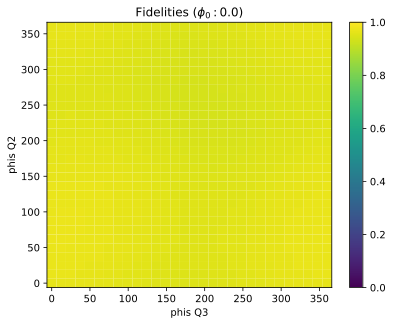

init state Q0 (switch) Q1 (input): |0>|0+1>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 37.471554065513665
(30, 30)
phi Q0 0.0


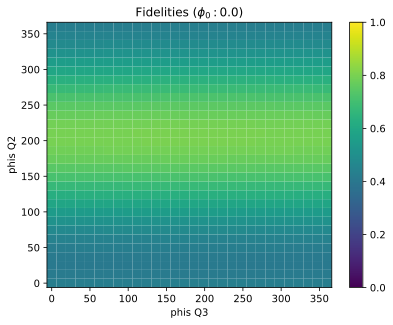

init state Q0 (switch) Q1 (input): |1>|0+1>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 5.519414539575296
(30, 30)
phi Q0 0.0


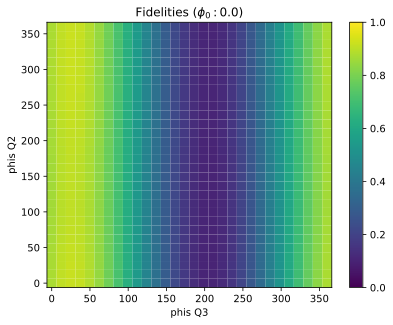

init state Q0 (switch) Q1 (input): |0+1>|1>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 50.36318047538826
(30, 30)
phi Q0 0.0


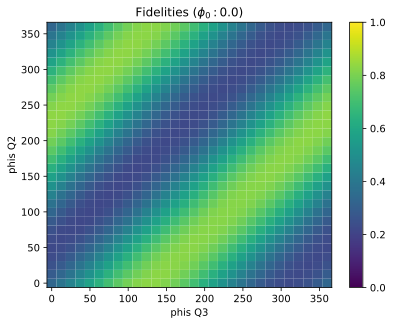

init state Q0 (switch) Q1 (input): |0+1>|0+1>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 53.04467441242494
(30, 30)
phi Q0 0.0


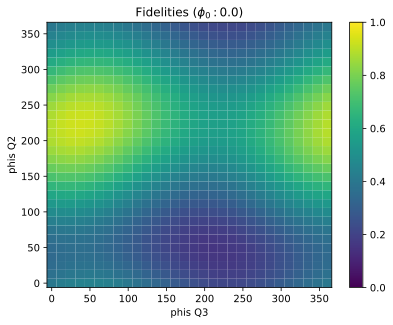

init state Q0 (switch) Q1 (input): |0>|0>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 1.6096624590390518
(30, 30)
phi Q0 0.0


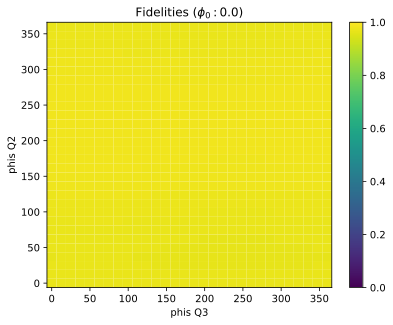

init state Q0 (switch) Q1 (input): |1>|0>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 0.3554729432557302
(30, 30)
phi Q0 0.0


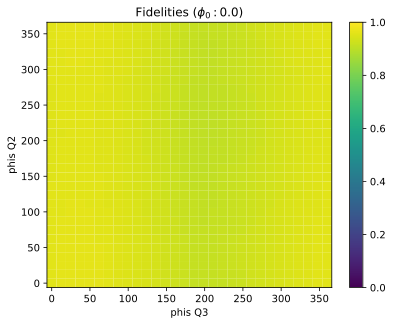

init state Q0 (switch) Q1 (input): |1>|1>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 2.7138102901331562
(30, 30)
phi Q0 0.0


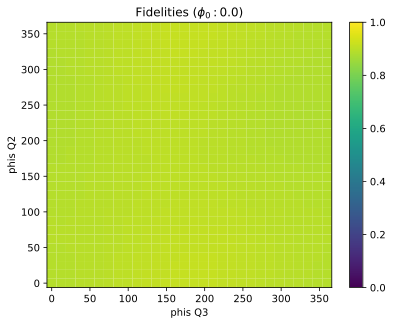

init state Q0 (switch) Q1 (input): |0>|1>
constructing final state on |switch, out1, out2>


  0%|          | 0/27000 [00:00<?, ?it/s]

Improved fidelity by (%) 0.6885495251742202
(30, 30)
phi Q0 0.0


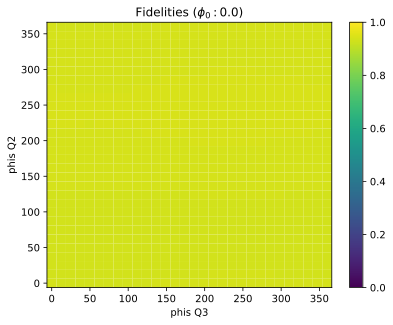

In [64]:
for i_saved_file, saved_file in enumerate(tqdm(saved_files)):
    init_state = init_states[i_saved_file]
    print('init state Q0 (switch) Q1 (input):', init_state)
    
    init_rho = rho_MLE_ZZ_dict[init_state]
    # init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
    rho_id = get_qram_qSLR_state_from_rho(init_rho)
    # ------------------------------ #
    # MLE with opt rot
    # ------------------------------ #
    rho_MLE_ZZ = rhos_ZZ[i_saved_file]
    rho_MLE = rho_MLE_ZZ
    
    phis[0] = np.linspace(0, 360, 30) # Q0
    phis[1] = np.linspace(0, 360, 30) # Q2
    phis[2] = np.linspace(0, 360, 30) # Q3
    if init_state == '|0+1>|0+1>' or init_state == '|0+1>|1>': phis[0] = np.linspace(0, 360, 30)
        
    rho_MLE_rot, best_phis, best_fid, fids_grid = tomo_analysis.opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis, progress=True)
    fids_grids.append(fids_grid)
    
    inner_sweep = phis[2]
    outer_sweep = phis[1]
    y_sweep = outer_sweep
    x_sweep = inner_sweep

    # vmax = np.max(fids_grid)
    vmax = 1.0
    # for i_phi0, phi0 in enumerate(phis[0]):
    for i_phi0, phi0 in enumerate([phis[0][0]]):
        print(fids_grid[i_phi0].shape)
        print(f'phi Q0 {phi0}')
        plt.figure()
        plt.title(f'Fidelities ($\phi_0: ${phi0:0.4})')
        plt.xlabel(f'phis Q{tomo_qubits[2]}')
        plt.ylabel(f'phis Q{tomo_qubits[1]}')
        plt.pcolormesh(x_sweep, y_sweep, fids_grid[i_phi0], cmap='viridis', shading='auto')
        plt.colorbar()
        plt.clim(vmin=0, vmax=vmax)
        plt.show()

    z_phi123 = tomo_analysis.z_gate_nq(best_phis)
    rho_MLE_rot = (z_phi123*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi123.dag()).unit()
    fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2
    
    purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
    purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    # print(f'Fidelity (after rotation): {fid_rot}')
    # print(f'Purity (after rotation): {purity_MLE_rot}')
    # print(f'Target purity: {purity_id}')
    # print(f'Best rotation: {best_phis}')
    
    # if saveplots: savetitle=saved_file[:-3]+f'_ZZcorrect_optrot{save_append}.svg'
    # else: savetitle = None
    # show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)
    
    fidelities_opt_rot.append(best_fid)
    all_best_phis.append(best_phis)
    
    # print('\n\n\n')

In [65]:
print(np.array(fids_grids).shape)
print(len(init_states))

(9, 30, 30, 30)
9


In [66]:
print('Input states', init_states)
print('Saved files', saved_files)
print('fidelities base MLE\n', fidelities_base)
print('ZZ correction fidelities\n', fidelities_ZZ)
# print('Optimal phi with base MLE fidelities\n', fidelities_opt_rot)
print('Optimal phi with ZZ correction fidelities\n', fidelities_opt_rot)
print('best_phis\n', all_best_phis)
print('purities (base MLE)\n', purities_base)
print('purities (ZZ correction)\n', purities_ZZ)

Input states ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
Saved files ['S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00090_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00091_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00092_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00093_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00094_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00095_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00096_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00097_QramProtocol3QTomo.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00098_QramProtocol3QTomo.h5']
fidelities base MLE
 [0.9576636356073701, 0.40780039287239783, 0.87171461958762

Go through the fids grids and select the best overall phi

(9, 30, 30, 30)
|0+1>|0>
best phi Q0 347.58620689655174


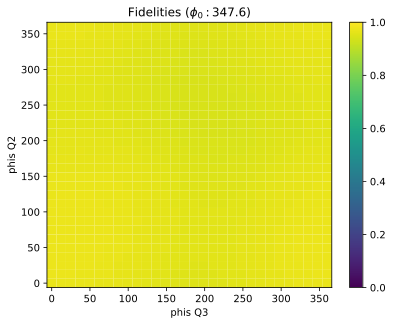

|0>|0+1>
best phi Q0 347.58620689655174


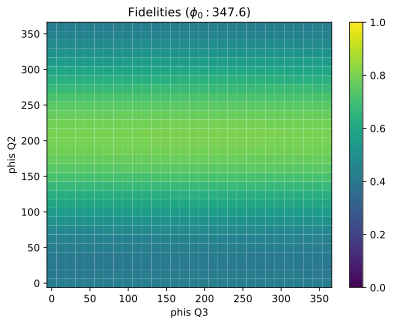

|1>|0+1>
best phi Q0 347.58620689655174


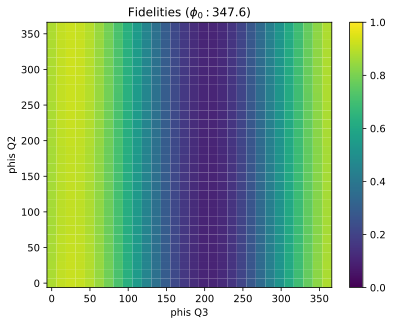

|0+1>|1>
best phi Q0 347.58620689655174


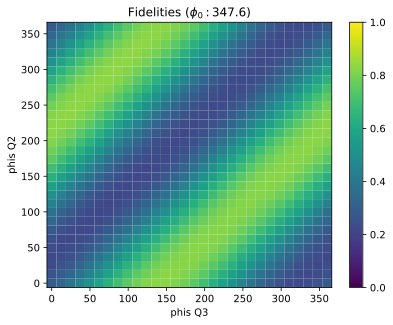

|0+1>|0+1>
best phi Q0 347.58620689655174


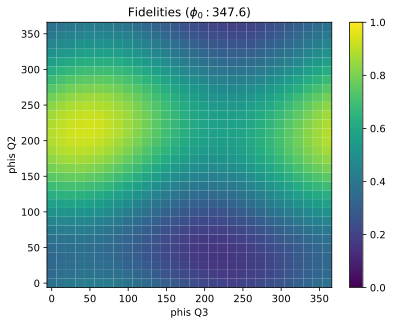

|0>|0>
best phi Q0 347.58620689655174


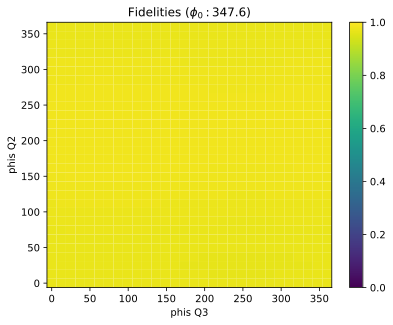

|1>|0>
best phi Q0 347.58620689655174


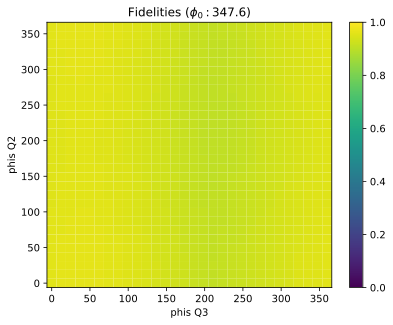

|1>|1>
best phi Q0 347.58620689655174


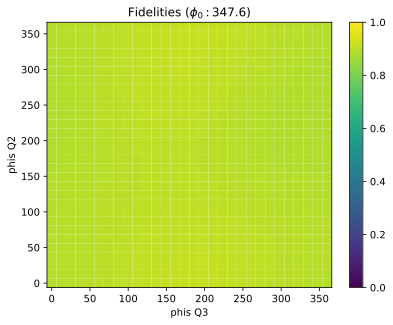

|0>|1>
best phi Q0 347.58620689655174


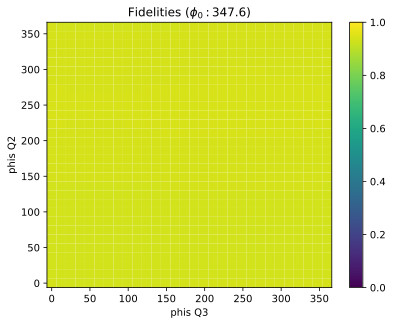

best avg fid 0.9054728463488932
best fids for check states [0.9564209693473584, 0.7862044449035722, 0.9148230424149885, 0.8140066277070853, 0.9198495139207826, 0.9800512786675674, 0.9541335242869078, 0.886280881849097, 0.9374853340426782]
best phis [347.58620689655174, 223.44827586206895, 24.82758620689655]


In [67]:
use_ZZ_mat = True

# Pick best overall phi

phis[0] = np.linspace(0, 360, 30) # Q0
# phis[0] = [0] # Q00
phis[1] = np.linspace(0, 360, 30) # Q2
phis[2] = np.linspace(0, 360, 30) # Q3

# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0>']
# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0>']
# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>', '|0+1>|0>', '|0+1>|0+1>']
# check_init_states = ['|1>|0+1>', '|0>|0+1>', '|0+1>|1>']
# check_init_states = ['|0+1>|0+1>']
check_init_states = init_states
    

fids_grids_reshaped = []
for i_state in range(len(init_states)):
    grid_shape = fids_grids[i_state].shape
    # print(grid_shape)
    fids_grid = np.copy(fids_grids[i_state]).tolist()
    # print(init_states[i_state], grid_shape)
    if grid_shape[0] == 1:
        for i in range(grid_shape[1]-1):
            fids_grid.append(fids_grid[0])
    # print(np.array(fids_grid).shape)
    fids_grids_reshaped.append(fids_grid)
    
fids_grids_reshaped = np.array(fids_grids_reshaped)
print(fids_grids_reshaped.shape)


best_avg_fid = 0
best_fids = []
best_phis = [0, 0, 0]
best_phi_indices = [0, 0, 0]
for iphi0, phi0 in enumerate(phis[0]):
    for iphi1, phi1 in enumerate(phis[1]):
        for iphi2, phi2 in enumerate(phis[2]):
            avg_fid = 0
            for i_state, init_state in enumerate(init_states):
                if init_state not in check_init_states: continue
                avg_fid += fids_grids_reshaped[i_state][iphi0, iphi1, iphi2]
            avg_fid /= len(check_init_states)
            if avg_fid > best_avg_fid:
                best_phis = [phi0, phi1, phi2]
                best_phi_indices = [iphi0, iphi1, iphi2]
                best_avg_fid = avg_fid
 
vmax = 1.0
for i_state in range(len(init_states)):
    print(init_states[i_state])
    print(f'best phi Q0 {best_phis[0]}')
    plt.figure()
    plt.title(f'Fidelities ($\phi_0: ${best_phis[0]:0.4})')
    plt.xlabel(f'phis Q{tomo_qubits[2]}')
    plt.ylabel(f'phis Q{tomo_qubits[1]}')
    plt.pcolormesh(x_sweep, y_sweep, fids_grids_reshaped[i_state, best_phi_indices[0], :, :], cmap='viridis', shading='auto')
    plt.colorbar()
    plt.clim(vmin=0, vmax=vmax)
    plt.show()


for i_state, init_state in enumerate(init_states):
    if init_state not in check_init_states: continue
    best_fids.append(fids_grids_reshaped[i_state][best_phi_indices[0], best_phi_indices[1], best_phi_indices[2]])

print('best avg fid', best_avg_fid)
print('best fids for check states', best_fids)
print('best phis', best_phis)

Plot all the tomos for the best phis

In [97]:
best_phis = [360.0, 360.0, 235.86206896551724]


init_state |0+1>|0>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.912838901102987
Purity (after rotation): 0.8718032715209987
Target purity: 0.8909739460073554


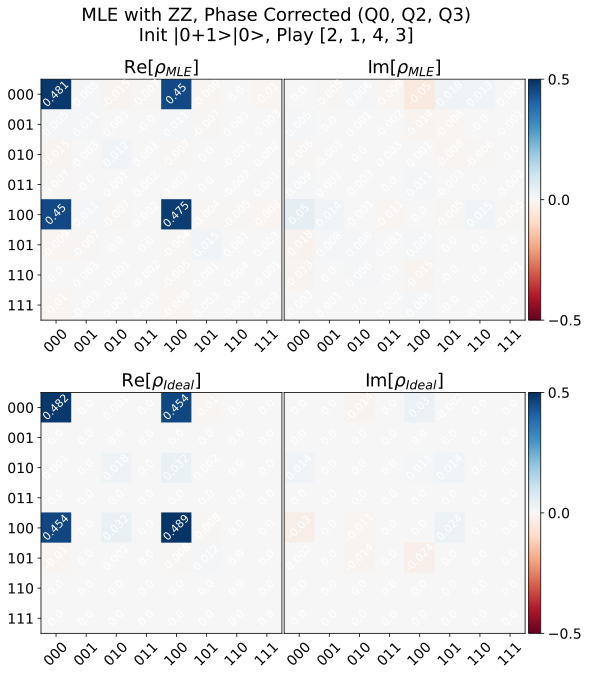


init_state |0>|0+1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.920526830692914
Purity (after rotation): 0.7487703316948598
Target purity: 0.9072598776404925


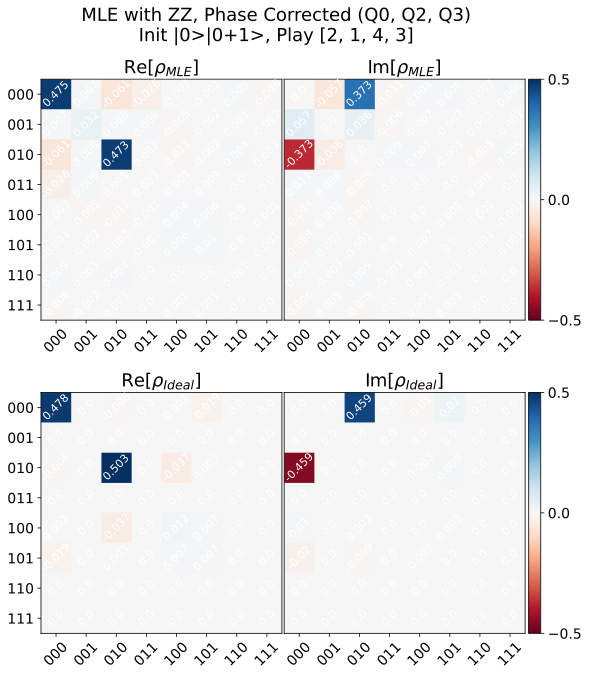


init_state |1>|0+1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.9274210146418346
Purity (after rotation): 0.7787771064283177
Target purity: 0.9518897216180454


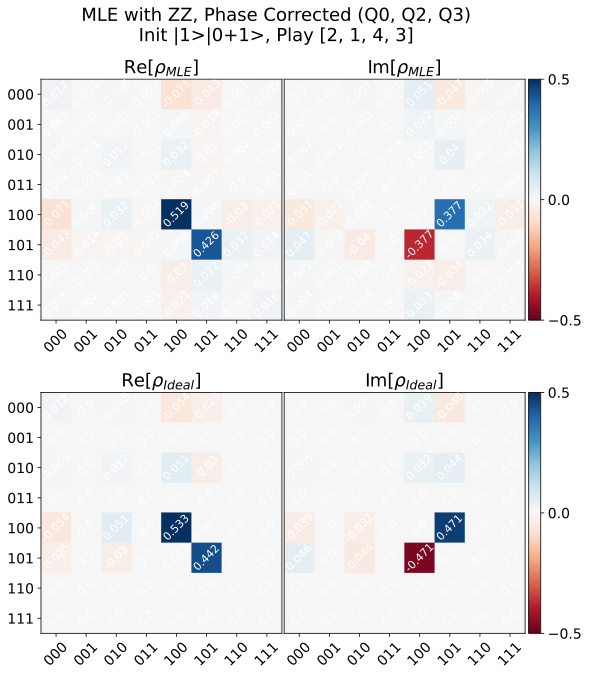


init_state |0+1>|1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.8851063283446978
Purity (after rotation): 0.71344589354293
Target purity: 0.8620525724713737


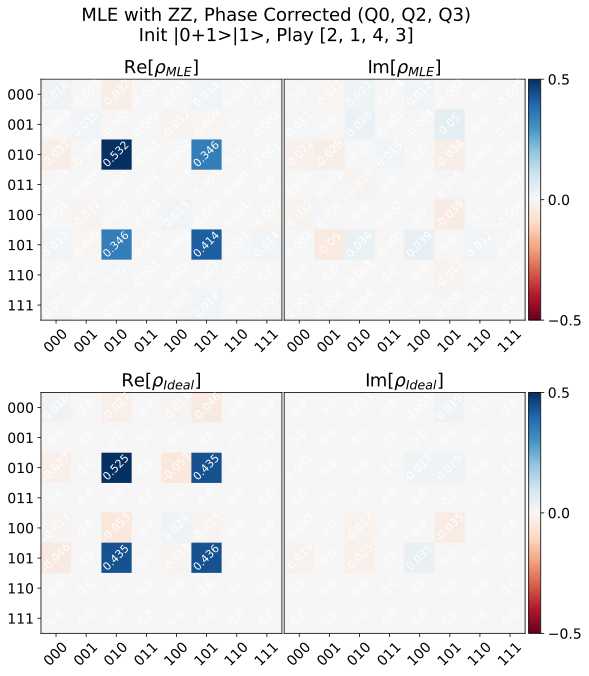


init_state |0+1>|0+1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.8472080442824699
Purity (after rotation): 0.7581631792104135
Target purity: 0.9569197415467203


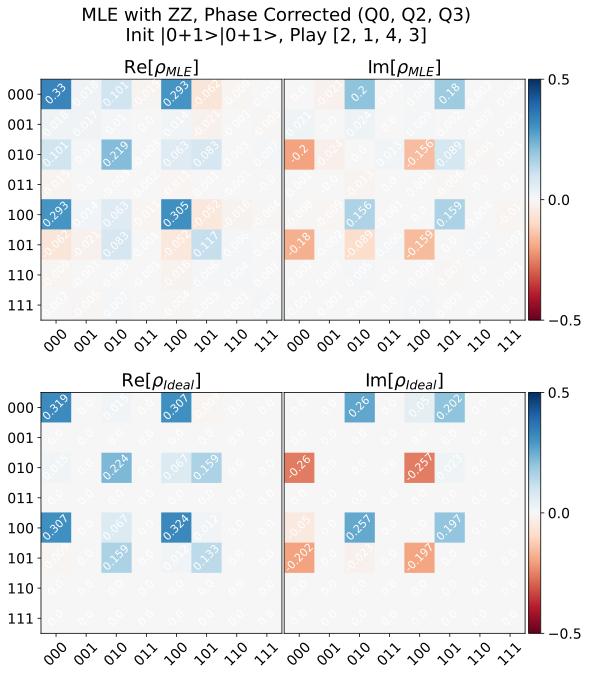


init_state |0>|0>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.971413800830929
Purity (after rotation): 0.9385980994699635
Target purity: 0.9732405951300862


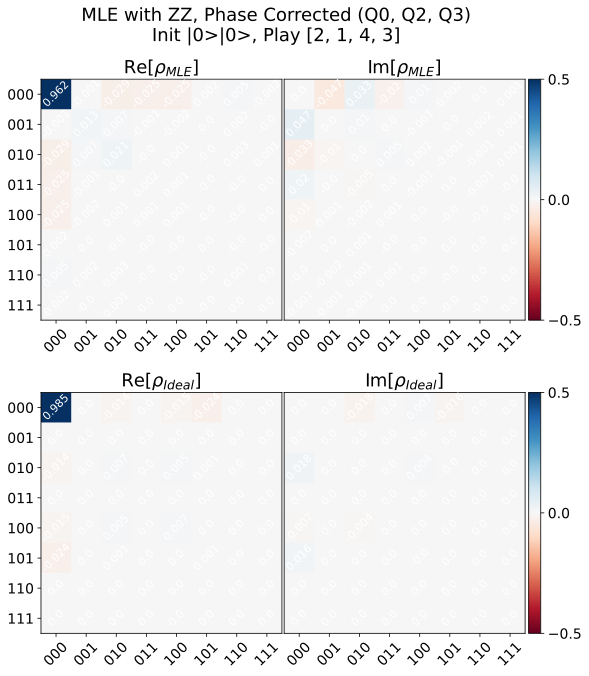


init_state |1>|0>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.9326124088718676
Purity (after rotation): 0.8935728795720158
Target purity: 0.9396495197510106


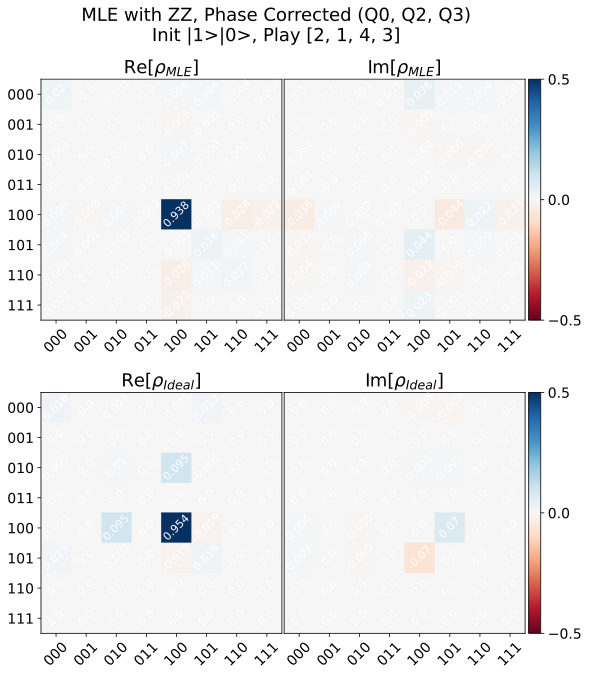


init_state |1>|1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.9224598410708696
Purity (after rotation): 0.8758609626997422
Target purity: 0.9114227103475363


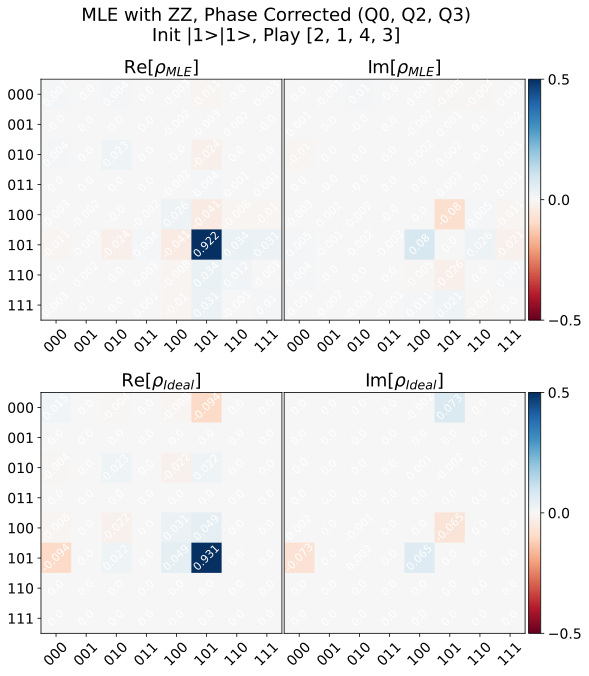


init_state |0>|1>
constructing final state on |switch, out1, out2>
Fidelity (after rotation): 0.9201880740166426
Purity (after rotation): 0.8624790790014712
Target purity: 0.9481220444035583


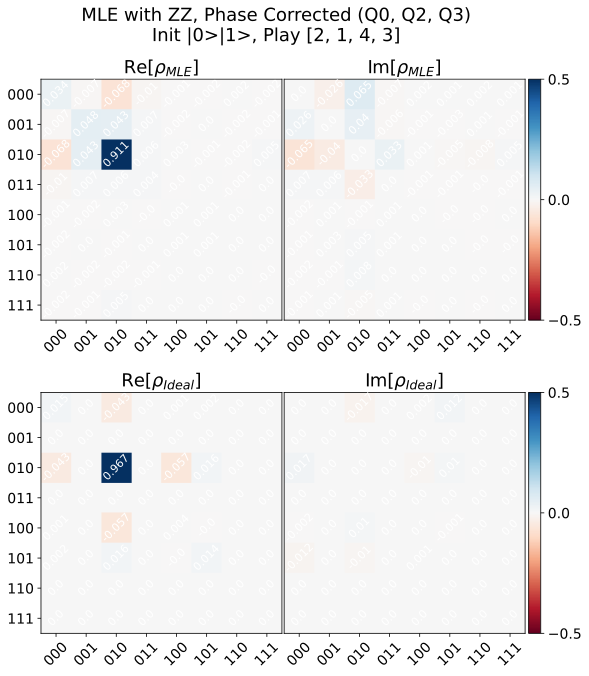


best fids
[0.912838901102987, 0.920526830692914, 0.9274210146418346, 0.8851063283446978, 0.8472080442824699, 0.971413800830929, 0.9326124088718676, 0.9224598410708696, 0.9201880740166426]
average best fid 0.9155305826505791
used best_phis [360.0, 360.0, 235.86206896551724]


In [98]:
z_phi123 = tomo_analysis.z_gate_nq(best_phis)
best_fids = []

print()
for i_state, init_state in enumerate(init_states):
    if init_state not in check_init_states: continue
    print('init_state', init_state)
    # init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
    init_rho = rho_MLE_ZZ_dict[init_state]
    rho_id = get_qram_qSLR_state_from_rho(init_rho)
    
    if use_ZZ_mat: rho_MLE_rot = (z_phi123*qt.Qobj(rhos_ZZ[i_state], dims=rho_id.dims)*z_phi123.dag()).unit()
    else: rho_MLE_rot = (z_phi123*qt.Qobj(rhos_base[i_state], dims=rho_id.dims)*z_phi123.dag()).unit()
    fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2
    best_fids.append(fid_rot)
    
    purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    print(f'Fidelity (after rotation): {fid_rot}')
    print(f'Purity (after rotation): {purity_MLE_rot}')
    print(f'Target purity: {purity_id}')
    
    if saveplots: savetitle=saved_file[:-3]+f'{"_ZZcorrect" if use_ZZ_mat else ""}_optrot{save_append}.svg'
    else: savetitle = None
    tomo_analysis.show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE {"with ZZ" if use_ZZ_mat else "Base"}, Phase Corrected (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})\nInit {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)
    print()
print('best fids')
print(best_fids)
print('average best fid', np.average(best_fids))
print('used best_phis', best_phis)

## Run analysis

### Reopen old data

In [72]:
apply_ps = False
# ps_adjust = [-0.3, -1.0, -0.3, -0.3]
ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [73]:
saved_files = []
filename = 'S:\Connie\experiments\qramLL_4QR2\data\data_240617\\00090_QramProtocol3QTomo.h5'
# data, attrs = prev_data(expt_path, '00009_QramProtocol3QTomo.h5')
saved_files.append(filename)
data, attrs = prev_data(filename, None)
pulse_dict = attrs['pulse_dict']
print('calib_order', attrs['calib_order'])
print('meas_order', attrs['meas_order'])

print(data.keys())
# # data = None
# # style.use('default')
# # qramExpt.analyze(data=data)
# # qramExpt.display(data=data, err=False, saveplot=True)
# # print(data)

cfg = AttrDict(attrs['config'])
init_state = cfg.expt.init_state
play_pulses = cfg.expt.play_pulses
tomo_qubits = cfg.expt.tomo_qubits
print('init_state', init_state)
print('play_pulses', play_pulses)
print('tomo_qubits', tomo_qubits)

np.set_printoptions(suppress=True)
n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)
print('counts_calib')
n_calib = n_calib.astype(np.float64)
for r in range(n_calib.shape[0]):
    n_calib[r,:]/=np.sum(n_calib[r,:])
print(n_calib)
print(attrs['calib_order'])

print(f'thresholds={data["thresholds"].tolist()},')
print(f'angles={data["angles"].tolist()},')
print(f'ge_avgs={data["ge_avgs"].tolist()}',',')
print(f'counts_calib={data["counts_calib"].tolist()}')

S:\Connie\experiments\qramLL_4QR2\data\data_240617\00090_QramProtocol3QTomo.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_20576\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
calib_order ['ggg', 'gge', 'geg', 'gee', 'egg', 'ege', 'eeg', 'eee']
meas_order ['ZZZ', 'ZZX', 'ZZY', 'ZXZ', 'ZXX', 'ZXY', 'ZYZ', 'ZYX', 'ZYY', 'XZZ', 'XZX', 'XZY', 'XXZ', 'XXX', 'XXY', 'XYZ', 'XYX', 'XYY', 'YZZ', 'YZX', 'YZY', 'YXZ', 'YXX', 'YXY', 'YYZ', 'YYX', 'YYY']
dict_keys(['angles', 'calib_ishots_raw', 'calib_qshots_raw', 'counts_calib', 'counts_raw', 'counts_tomo', 'epop', 'fpop', 'ge_avgs', 'gpop', 'ishots_raw', 'qshots_raw', 'thresholds', 'xpts'])
init_state |0+1>|0>
play_pulses [2, 1, 4, 3]
tomo_qubits [0, 2, 3]
counts_calib
[[0.79750667 0.08037333 0.05013333 0.00538667 0.05530667 0.00665333
  0.00350667 0.00113333]
 [0.11701333 0.76388    0.00797333 0.04653333 0.00870667 0.05112
  0.001      0.00377333]
 [0.07065333 0.00714667 0.78636    0.07002667 0.00498667 0.00088
  0.054      0.00594667]
 [0.01166667 0.06532    0.13045333 0.72989333 0.00089333 0.00452
  0.00913333 0.04812   ]
 [0.15816    0.0

In [ ]:
# # counts_calib = data['counts_calib']
# counts_calib=[array([3189,  426, 3176,  519, 1176,  198, 1110,  206]), array([ 580, 3047,  582, 3015,  207, 1148,  221, 1200]), array([1963,  289, 4456,  583,  721,   97, 1661,  230]), array([ 390, 1850,  812, 4372,  130,  683,  269, 1494]), array([1336,  209, 1293,  232, 2954,  473, 2981,  522]), array([ 256, 1341,  226, 1320,  512, 2924,  557, 2864]), array([ 809,  118, 1892,  295, 1810,  262, 4215,  599]), array([ 167,  796,  352, 1830,  325, 1776,  781, 3973])]


# # introduce gaussian noise
# np.random.seed(0)
# noise = 2.0
# n = np.copy([counts_calib[4]])
# print(n, sum(n))
# n0 = correct_readout_err(n, n_conf=counts_calib)
# print('correct readout err', n0)
# print('fix neg counts', fix_neg_counts(n0))

# if noise is not None:
#     for n_psi in n:
#         n_meas = sum(n_psi)
#         new_nlast = -1
#         while new_nlast < 0:
#                 new_n_uptolast = np.random.normal(loc=n_psi[:-1], scale=noise*np.sqrt(n_psi[:-1]))
#                 # new_n_uptolast *= 1 - np.isnan(new_n_uptolast) # 0 out the nans
#                 # print('here', new_n_uptolast)
#                 # preserve original total count per measurement
#                 new_nlast = n_meas - sum(new_n_uptolast)
#                 n_psi[:-1] = np.round(new_n_uptolast)
#                 n_psi[-1] = np.round(new_nlast)

# print(1)
# print(n, sum(n))
# print(type(n))
# print(np.shape(n))
# print(n[0].dtype)
# n = np.array(n, dtype=float)
# n1 = correct_readout_err(n, n_conf=counts_calib)
# print('correct readout err', n1)
# print('fix neg counts', fix_neg_counts(n1))


# # print('n1-n2')
# # print(n1-n2)

# print(3)
# n = [[ 287, 1291,  675, 2954,  256, 1250,  554, 2733]]
# print(n)
# n = correct_readout_err(n, n_conf=counts_calib)
# print(sum(n))
# print(fix_neg_counts(n))

# print(4)
# correct_readout_err(counts_calib, counts_calib)

### Set ideal rho

Get ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

### Get final qram state from an arbitrary 2Q input density matrix

In [61]:
print('init state Q0 (switch) Q1 (input):', init_state)

# init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
# if init_state == '|0+1>|0+1>':
#     init_rho = np.array([[(0.23+0j), (0.057+0.233j), (0.18-0.099j), (-0.078+0.08j)], [(0.057-0.233j), (0.287+0j), (-0.016-0.171j), (-0.013+0.114j)], [(0.18+0.099j), (-0.016+0.171j), (0.266+0j), (-0.166+0.121j)], [(-0.078-0.08j), (-0.013-0.114j), (-0.166-0.121j), (0.217+0j)]])
# init_rho = qt.ket2dm((name_to_state_2q('|1>|0>') + name_to_state_2q('|1>|1>') + name_to_state_2q('|0>|0>') + 1j*name_to_state_2q('|0>|1>')).unit())

# rho_id = get_qram_qSLR_state_from_rho(init_rho)
# rho_id


# # rho_MLE_ZZ_2Q_filepath = 'S:\Connie\experiments\qramLL_4QR2\data\data_240218\\202402281619_init_rhoMLE_ZZ_2Q_01.npz'
# rho_MLE_ZZ_2Q_filepath = 'S:\Connie\experiments\qramLL_4QR2\data\data_240218\\202402291250_init_rhoMLE_ZZ_2Q_01.npz'

# print(f'Using rho_MLE_ZZ for Q0/Q1 from file {rho_MLE_ZZ_2Q_filepath}')

# rho_MLE_ZZ_dict = dict()
# with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
#     for key in npzfile.keys():
#         rho_MLE_ZZ_dict.update({key:npzfile[key]})
# print(f'rho_MLE_ZZ retrieved with init_states {rho_MLE_ZZ_dict.keys()}')
init_rho = rho_MLE_ZZ_dict[init_state]
rho_id = get_qram_qSLR_state_from_rho(init_rho)

init state Q0 (switch) Q1 (input): |0>|1>
constructing final state on |switch, out1, out2>


In [88]:
# psi_id = qt.tensor(psiZ[1]+psiZ[0], psiZ[0], psiZ[1]+psiZ[0]).unit()
# psi_id = qt.tensor(psiZ[1], psiZ[0], psiZ[1]).unit()
# rho_id = qt.ket2dm(psi_id)
# rho_id = qt.ket2dm(psis['010'] + psis['011']).unit()
rho_id = qt.ket2dm(psis['010']).unit()
# print(rho_id.dims)

### Generate test data

In [ ]:
# rho_id = qt.ket2dm(psi10 + psi11).unit()

# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
n_tomo_sim = generate_counts(rho_id=rho_id, n_tot=100000, evol_mats=evol_mats, noise=None)
# n_tomo = generate_counts(rho_id=rho_MLE_ZZ, n_tot=100000, evol_mats=evol_mats, noise=None)
# n_tomo = n_tomo_sim
print(n_tomo_sim)

print(meas_order)
print(calib_order)
print('difference')
print(np.round((n_tomo_sim - n_tomo)/100000, 2))

In [ ]:
# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, evol_mats=evol_mats, noise=None)
# n_calib = qt.qeye(4).full()
# print(fix_neg_counts(n_tomo))

### Run MLE without ZZ correction

In [155]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
# rho_MLE_base = run_MLE(n=n_tomo, rho_id=rho_id, ZZ_correction=False, method='L-BFGS-B')
rho_MLE_base = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=False,
)

print(rho_MLE_base)

[[ 0.02977909+0.j         -0.00397974-0.00093391j -0.00135111-0.00048677j
   0.00041421+0.00116623j -0.01469723+0.00816138j  0.00534773+0.02920598j
   0.00201421+0.00120773j  0.00125141+0.00223413j]
 [-0.00397974+0.00093391j  0.00725183+0.j          0.00039415+0.00094411j
   0.00031345+0.00014624j -0.01200877+0.00064929j -0.00458346+0.00766711j
  -0.00583649+0.00089608j -0.00059678-0.00276376j]
 [-0.00135111+0.00048677j  0.00039415-0.00094411j  0.00326836+0.j
   0.00027392-0.00031511j -0.00347405+0.00110501j -0.00390293+0.00036131j
   0.0007444 +0.00061308j -0.00068202+0.0000858j ]
 [ 0.00041421-0.00116623j  0.00031345-0.00014624j  0.00027392+0.00031511j
   0.00278766+0.j         -0.00485581-0.0025482j   0.00299751-0.00564059j
   0.00003895+0.0010996j  -0.00074552+0.00098928j]
 [-0.01469723-0.00816138j -0.01200877-0.00064929j -0.00347405-0.00110501j
  -0.00485581+0.0025482j   0.06804836-0.j          0.02860712+0.01108196j
   0.00269275-0.00184104j -0.00060915+0.0022547j ]
 [ 0.00534773

Fidelity (no ZZ correction): 0.0032683580062633573
Purity (no ZZ correction): 0.7813633736630816
[[ 0.03 +0.j    -0.004-0.001j -0.001-0.j     0.   +0.001j -0.015+0.008j
   0.005+0.029j  0.002+0.001j  0.001+0.002j]
 [-0.004+0.001j  0.007+0.j     0.   +0.001j  0.   +0.j    -0.012+0.001j
  -0.005+0.008j -0.006+0.001j -0.001-0.003j]
 [-0.001+0.j     0.   -0.001j  0.003+0.j     0.   -0.j    -0.003+0.001j
  -0.004+0.j     0.001+0.001j -0.001+0.j   ]
 [ 0.   -0.001j  0.   -0.j     0.   +0.j     0.003+0.j    -0.005-0.003j
   0.003-0.006j  0.   +0.001j -0.001+0.001j]
 [-0.015-0.008j -0.012-0.001j -0.003-0.001j -0.005+0.003j  0.068-0.j
   0.029+0.011j  0.003-0.002j -0.001+0.002j]
 [ 0.005-0.029j -0.005-0.008j -0.004-0.j     0.003+0.006j  0.029-0.011j
   0.878+0.j    -0.001-0.003j  0.002+0.002j]
 [ 0.002-0.001j -0.006-0.001j  0.001-0.001j  0.   -0.001j  0.003+0.002j
  -0.001+0.003j  0.009+0.j     0.   +0.002j]
 [ 0.001-0.002j -0.001+0.003j -0.001-0.j    -0.001-0.001j -0.001-0.002j
   0.002-0.002j

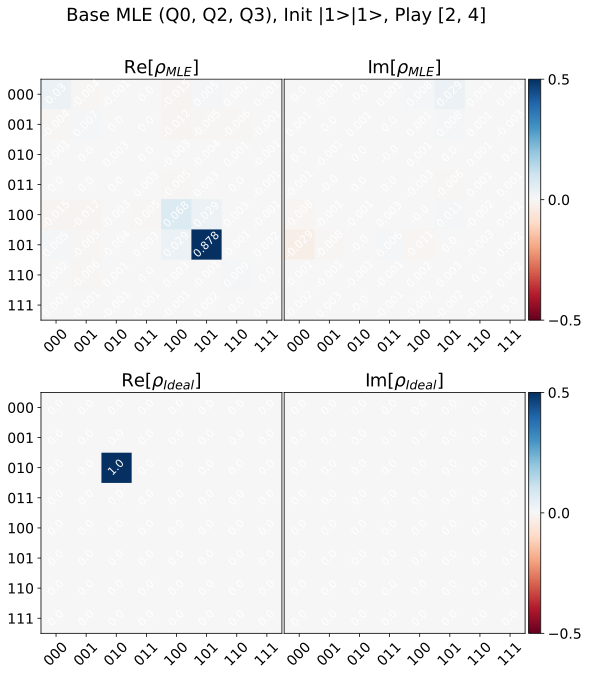

Saved data:



In [156]:
fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
print(f'Fidelity (no ZZ correction): {fid_base}')
print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE_base, decimals=3))
tomo_analysis.show_plot_rho_2d(rho_MLE_base, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', cmax=0.5)

print('Saved data:')
print(*saved_files)

### Run MLE with ZZ

#### Get evol mats for ZZ

In [158]:
# Recover old config
# yaml_cfg = AttrDict(attrs['config'])

In [29]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [30]:
evol_mats_path = os.path.join(os.getcwd(), 'evol_mats')
print('Will save evol mats to path', evol_mats_path)

qA, qB, qC = tomo_qubits
evol_mats_filename = f'evol_mats_{qA}{qB}{qC}.npz'
print('Will save to filename', evol_mats_filename)

Will save evol mats to path S:\Connie\experiments\qramLL_4QR2\evol_mats
Will save to filename evol_mats_023.npz


In [163]:
f_ge = np.array([f + (4000 if f < 1000 else 0) for f in np.reshape(yaml_cfg.device.qubit.f_ge, (4,4)).diagonal()]) # MHz
f_ef = np.array([f + (4000 if f < 1000 else 0) for f in np.reshape(yaml_cfg.device.qubit.f_ef, (4,4)).diagonal()]) # Mhz

# f_ge = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ge]) # MHz
# f_ef = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ef]) # Mhz
# gs = np.array([51, 51, 36, 9, 8, 3.5]) # MHz

qA, qB, qC = tomo_qubits
print('TOMO QUBITS', tomo_qubits)
ZZs_4q = np.zeros((4,4))
reshaped_f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
for row in range(4):
    ZZs_4q[row,:] = reshaped_f_ge[row,:] - reshaped_f_ge[row,row]

f_ge = np.array([f_ge[qA], f_ge[qB], f_ge[qC]])
f_ef = np.array([f_ef[qA], f_ef[qB], f_ef[qC]])
alphas = f_ef - f_ge # MHz
ZZs = np.zeros(shape=(3, 3))
ZZs = ZZs_4q[tomo_qubits][:,tomo_qubits]

# ZZs = 0*ZZs
# ZZs = 10*ZZs

print('qubit freqs', f_ge)
# print('alphas', alphas)
print('ZZs (MHz)', ZZs)
# print(pulse_dict)

print('Will save to filename', evol_mats_filename)

evol_mats = tomo_analysis.get_evol_mats(qubits=tomo_qubits, qfreqs=f_ge*1e-3, alphas=alphas*1e-3, ZZs=ZZs*1e-3, pulse_dict=pulse_dict, soccfg=soc, debug=False)
# evol_mats = get_evol_mats(qubits=qubits, qfreqs=f_ge*1e-3, alphas=alphas*1e-3, gs=gs*1e-3, pulse_dict=pulse_dict)

# print(evol_mats)

evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
np.savez(evol_mats_file_path, **evol_mats)
print(f'Saved evol mats to file {evol_mats_file_path}')

TOMO QUBITS [0, 2, 3]
qubit freqs [4110.42824795 4762.20157232 4381.6795443 ]
ZZs (MHz) [[ 0.         -0.22967106 -0.55809684]
 [-0.1408671   0.         -0.52353906]
 [-0.53768634 -0.53692257  0.        ]]
Will save to filename evol_mats_023.npz


  0%|          | 0/27 [00:00<?, ?it/s]

Saved evol mats to file S:\Connie\experiments\qramLL_4QR2\evol_mats\evol_mats_023.npz


#### Reload evol mats

In [31]:
qA, qB, qC = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
# evol_mats_file_path = os.path.join(evol_mats_path, f'evol_mats_{qA}{qB}{qC}_test.npz')
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})
# print(evol_mats)

Using evol mats from file S:\Connie\experiments\qramLL_4QR2\evol_mats\evol_mats_023.npz


#### (Actually) run MLE with ZZ correction

In [165]:
rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=True,
    evol_mats=evol_mats
)

 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 757ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 762

In [ ]:
# GET IDEAL RHO FROM DICTIONARY
print('init state to get ideal rho', init_state)
init_rho = rho_MLE_ZZ_dict[init_state]
rho_id = get_qram_qSLR_state_from_rho(init_rho)

[[ 0.03 +0.j    -0.005-0.j    -0.002+0.j     0.001+0.001j -0.017+0.01j
   0.001+0.023j  0.002+0.001j  0.001+0.002j]
 [-0.005+0.j     0.007+0.j     0.   +0.001j -0.   +0.j    -0.006+0.002j
  -0.016+0.016j -0.006+0.001j  0.   -0.003j]
 [-0.002-0.j     0.   -0.001j  0.003+0.j     0.   -0.j    -0.003+0.001j
  -0.002-0.j     0.   +0.001j -0.001-0.j   ]
 [ 0.001-0.001j -0.   -0.j     0.   +0.j     0.003+0.j    -0.005-0.001j
   0.004-0.006j  0.   +0.001j -0.001+0.001j]
 [-0.017-0.01j  -0.006-0.002j -0.003-0.001j -0.005+0.001j  0.068+0.j
   0.012+0.027j  0.002-0.001j -0.001-0.001j]
 [ 0.001-0.023j -0.016-0.016j -0.002+0.j     0.004+0.006j  0.012-0.027j
   0.878-0.j     0.001-0.003j -0.005+0.008j]
 [ 0.002-0.001j -0.006-0.001j  0.   -0.001j  0.   -0.001j  0.002+0.001j
   0.001+0.003j  0.009-0.j    -0.001+0.002j]
 [ 0.001-0.002j  0.   +0.003j -0.001+0.j    -0.001-0.001j -0.001+0.001j
  -0.005-0.008j -0.001-0.002j  0.002+0.j   ]]
Fidelity (with ZZ correction): 0.003312109786833566
Purity (with ZZ

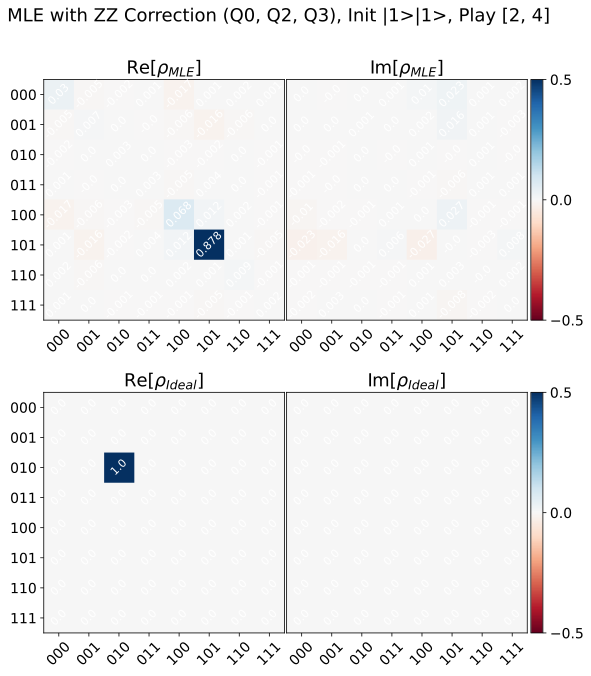

In [166]:
print(np.around(rho_MLE_ZZ, decimals=3))
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')
print(f'Target purity: {purity_id}')
# savetitle = '1_0+1_ideal.png'
# savetitle = 'test.png'
savetitle=None

if savetitle is None: plt.style.use('default')
# show_plot_rho_2d(rho_id, rho_id, title='MLE with ZZ Correction', savetitle=savetitle) #, cmax=1.0)
print('init state', init_state)
tomo_analysis.show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]}), Init {init_state}, Play {play_pulses}', savetitle=savetitle, cmax=0.5)

if save_data:
    print('Saved data:')
    print(saved_files[-1])

### Optimize over virtual Z gates on ideal rho 

Optimize over virtual Z gates on ideal rho 

In [68]:
# rho_MLE = rho_MLE_base
rho_MLE = rho_MLE_ZZ

In [69]:
phis = [None, None, None]
phis[0] = np.linspace(0, 360, 40)
phis[1] = np.linspace(0, 360, 40)
phis[2] = np.linspace(0, 360, 40)
# phis[0] = np.linspace(0, 360, 1)
# phis[1] = np.linspace(0, 360, 100)
# phis[2] = np.linspace(0, 360, 100)

rho_MLE_rot, best_phis, best_fid, fids_grid = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)
print('Rotation:', best_phis)

Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
 C:\Users\slab\AppData\Local\Temp\ipykernel_2540\425015463.py: 13

  0%|          | 0/40 [00:00<?, ?it/s]

Improved fidelity by (%) 11.465662672047639
Rotation: [101.53846153846153, 286.15384615384613, 221.53846153846152]


phi Q0 101.53846153846153
fid at phi2=286.15384615384613, phi3=221.53846153846152: 0.9156225067163491
Saved S:\Connie\experiments\qramLL_4QR2\data\data_240617\00033_QramProtocol3QTomo.svg


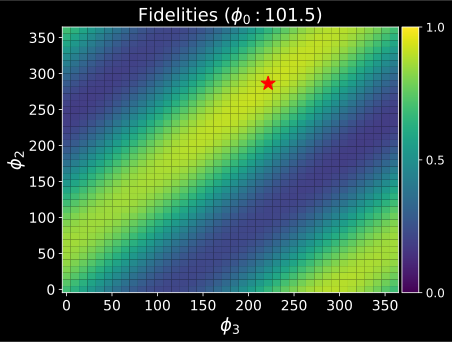

In [70]:
inner_sweep = phis[2]
outer_sweep = phis[1]
y_sweep = outer_sweep
x_sweep = inner_sweep

# vmax = np.max(fids_grid)
vmax = 1.0

# best_phis =  [350.7692307692307, 304.6153846153846, 138.46153846153845]
# best_phis =  [115, 350, 203]
# best_phis = [350.7692307692307, 18.46153846153846, 258.46153846153845]

saveplot = True
plot_filename = filename[:-3]+'.svg'
if saveplot: plt.style.use('dark_background')
best_phi_inds = [np.argmin(np.abs(phis[i]-best_phis[i])) for i in range(3)]

for i_phi0, phi0 in enumerate(phis[0]):
    if i_phi0 != best_phi_inds[0]: continue 
    print(f'phi Q0 {phi0}')
    plt.figure()
    plt.title(f'Fidelities ($\phi_0: ${phi0:0.4})', fontsize=18)
    plt.xlabel(f'$\phi_{tomo_qubits[2]}$', fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel(f'$\phi_{tomo_qubits[1]}$', fontsize=18)
    plt.yticks(fontsize=14)
    plt.pcolormesh(y_sweep, x_sweep, fids_grid[i_phi0], cmap='viridis', shading='auto')
    
    plt.plot([best_phis[2]], [best_phis[1]], 'r', marker='*', markersize=15)
    print(f'fid at phi2={best_phis[1]}, phi3={best_phis[2]}:', fids_grid[i_phi0][best_phi_inds[1]][best_phi_inds[2]])
    
    # old_best_phis = [0.0, 94.54545454545455, 349.09090909090907]
    # old_best_phis = [0.0, 196.36363636363635, 341.8181818181818]
    # plt.plot([old_best_phis[2]], [old_best_phis[1]], 'r', marker='o')
    
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, vmax])
    # cbar.ax.set_title(f'Fidelity')
    cbar.ax.tick_params(labelsize=12)
    plt.clim(vmin=0, vmax=vmax)
    
    if saveplot:
        plt.savefig(plot_filename, format='svg', bbox_inches='tight', transparent=True)
        print('Saved', plot_filename)
        
    plt.show()
    
# print(f'Difference between phi0[0] and phi0[1]')
# plt.figure()
# plt.title(f'Difference in fidelities ($\phi_0: $0 vs 30)')
# plt.xlabel(f'phis Q{tomo_qubits[2]}')
# plt.ylabel(f'phis Q{tomo_qubits[1]}')
# plt.pcolormesh(y_sweep, x_sweep, fids_grid[0]-fids_grid[1], cmap='viridis', shading='auto')

# # plt.plot([best_phis[2]], [best_phis[1]], 'r', marker='o')

# # old_best_phis = [0.0, 94.54545454545455, 349.09090909090907]
# # old_best_phis = [0.0, 196.36363636363635, 341.8181818181818]
# # plt.plot([old_best_phis[2]], [old_best_phis[1]], 'r', marker='o')

# plt.colorbar()
# # plt.clim(vmin=0, vmax=1)
# plt.show()

Fidelity (after rotation): 0.9156225067163491
Purity (after rotation): 0.7707817822307648
Target purity: 0.9088005114346163
Best rotation: [101.53846153846153, 286.15384615384613, 221.53846153846152]


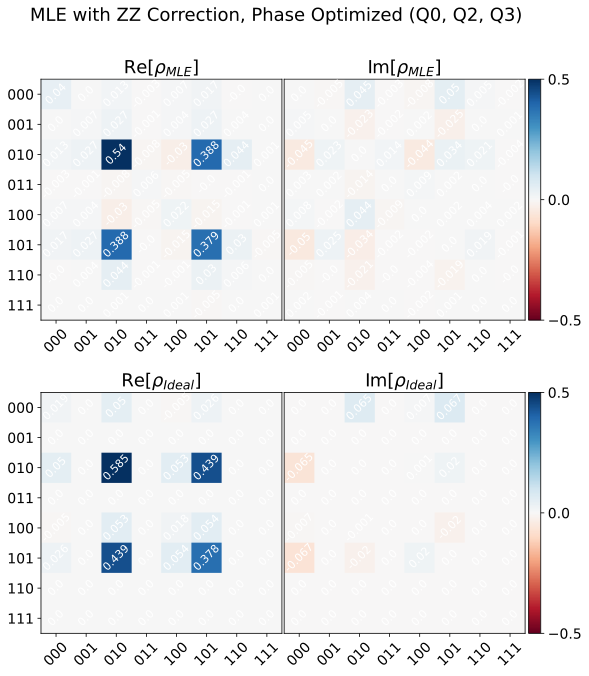

Saved data
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00033_QramProtocol3QTomo.h5


In [72]:
# best_phis = [0.0, 170.9090909090909, 254.54545454545453]
# best_phis = [0.0, 272.7272727272727, 167.27272727272728]
# best_phis = old_best_phis

z_phi123 = z_gate_3q(*best_phis)
rho_MLE_rot = (z_phi123*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi123.dag()).unit()
fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2

purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (after rotation): {fid_rot}')
print(f'Purity (after rotation): {purity_MLE_rot}')
print(f'Target purity: {purity_id}')
print(f'Best rotation: {best_phis}')

# print(np.around(rho_MLE_rot, decimals=3))
savetitle=None
# savetitle=saved_file[:-3]+f'_ZZcorrect_optrot.svg'
show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=savetitle, cmax=0.5)
print('Saved data')
print(saved_files[-1])

# Loop over 2Q sweep parameters

In [ ]:
# gain_sweep = np.linspace(2000, 25000, 11)
# opt_lens = 1e3*np.array([2.4201237152470587, 1.1987019004033739, 0.7868408797215013, 0.5851160587684981, 0.4716335769416996, 0.3999234927074055, 0.34781134410506404, 0.3089041362621608, 0.2818412962269934, 0.2636215545192442, 0.2512183319921639])
# opt_freqs = [5891.5, 5891.325, 5890.9, 5890.35, 5889.675, 5888.875, 5887.95, 5887.15, 5886.1, 5885.55, 5884.5]


gain_sweep = np.linspace(18000, 32000, 11)
opt_freqs = [5887.35, 5886.616666666667, 5885.883333333333, 5885.616666666667, 5885.116666666667, 5884.383333333333, 5884.116666666667, 5883.616666666667, 5882.883333333333, 5882.383333333333, 5882.583333333333]
opt_lens = [0.30514258121790533, 0.28952631508344284, 0.27703044436306967, 0.2646698856191053, 0.25368901625658447, 0.24735611563570364, 0.23874769989670325, 0.23044507614293083, 0.22816368954972915, 0.22170985331767395, 0.20962837376879714]

save_data = True
sweep2Q_q = 2
qubit = 2
play_pulses=[1,3]

In [ ]:
saved_files = []

init_state = '|0+1>|1>'

opt_phis = [None]

thresholds = None
angles = None
ge_avgs = None
counts_calib = None


for i_gain, gain in enumerate(gain_sweep):
    
    tomo = meas.QramProtocol3QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    
    span = np.inf
    npts = 1
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
    tomo.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
        reps=30000, # number of reps per tomo/time step,
        singleshot_reps=30000, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_3q=True,
        tomo_qubits=tomo_qubits,
        init_state=init_state,
        play_pulses=play_pulses,
        thresholds=thresholds,
        angles=angles,
        ge_avgs=ge_avgs,
        counts_calib=counts_calib,
    )
    tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_lens[i_gain]
    tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freqs[i_gain]
    print('gain', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q],
          'len', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q],
          'freq', tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q])
    try:
        tomo.go(analyze=False, display=False, progress=False, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    
    if save_data: saved_files.append(tomo.save_data())
    data = tomo.data
    if i_gain == 0:
        thresholds = data['thresholds']
        angles = data['angles']
        ge_avgs = data['ge_avgs']
        counts_calib = data['counts_calib']
    
    print()

In [ ]:
print(saved_files)

In [ ]:
print(saved_files)

### Calculate fidelities with ZZ correction and phase optimization

In [ ]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [ ]:
all_n_tomo = []
all_n_calib = []
all_fids = []
all_fids_rot = []

rho_id = qt.ket2dm(psis['001'] + psis['110']).unit()

for saved_file in saved_files:
    saved_file = saved_file.split('\\')
    # print(saved_file)
    data, attrs = prev_data(expt_path, saved_file[-1])
    pulse_dict = attrs['pulse_dict']
    cfg = AttrDict(attrs['config'])
    
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

    all_n_tomo.append(n_tomo_raw)
    all_n_calib.append(n_calib)

    rho_MLE = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_raw,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=True,
        evol_mats=evol_mats,
    )
    
    # show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=savetitle, cmax=0.5)
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"

    all_fids.append(fid_base)
    print('fid base', fid_base)
    
    rho_MLE_rot, best_phis, fid_rot = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)
    all_fids_rot.append(fid_rot)
    tomo_analysis.show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]}, Q{tomo_qubits[2]})', savetitle=None, cmax=0.5)
    print('fid rot', fid_rot)
    


In [ ]:
# print(all_n_tomo)
# print(all_n_calib)
# print(all_fids)
print('fidelity with optimized rotation\n', all_fids_rot)
print('saved files\n', saved_files)

In [ ]:
plt.plot(opt_lens, all_fids_rot, label='Q2 measured fidelity')

# decay_time = 10e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

# decay_time = 1e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

plt.xlabel(f'Length of 2Q swap in full protocol (ns)')
plt.ylabel(f'Q{sweep2Q_q} Fidelity')
plt.title(f'Q{sweep2Q_q}/Q1 parameter sweep from initial state {init_state}')
plt.legend()
plt.show()